In [94]:
#Read and Open CSVs
import pandas as pd
import numpy as np
import requests, zipfile, io
from pathlib import Path

# 0.  Where my other (local) CSVs live
DATA_DIR = Path(r"C:/Users/ad/Desktop/Data Science Learning Materials/Dissertation/Datasets")

# 1.  GDP (World Bank API, constant 2015 US$)
#     - Indicator code: NY.GDP.MKTP.KD
#     - The API delivers a zipped bundle containing three CSVs:
#         * …Data.csv      (wide table, one column per year)
#         * …Metadata.csv  (column descriptions)
#         * …Country.csv   (country metadata)

#1. GDP URL
gdp_indicator = "NY.GDP.MKTP.KD"
gdp_url = (f"https://api.worldbank.org/v2/country/all/indicator/{gdp_indicator}"
           "?downloadformat=csv")

# Fetch the ZIP into memory
resp = requests.get(gdp_url)
resp.raise_for_status()           # stop if the request failed

# Read the “…Data.csv” member straight into pandas
with zipfile.ZipFile(io.BytesIO(resp.content)) as z:
    csv_files = [n for n in z.namelist()
                 if n.lower().endswith(".csv")
                 and n.startswith("API_")
                 and "metadata" not in n.lower()]
    if not csv_files:
        raise ValueError("No data CSV found in World Bank ZIP")

    data_name = csv_files[0]

    with z.open(data_name) as f:
        # KEY CHANGE: skiprows=4 to ignore the metadata lines
        gdp_raw = pd.read_csv(
            f,
            skiprows=4,          # <—  skip the 4 non-tabular lines
            na_values="..",
            engine="python"      
        )

# Keep the columns we need and reshape
cols_to_drop = [c for c in
                ["Indicator Name", "Indicator Code",   # new names
                 "Series Name",    "Series Code"]      # old names
                if c in gdp_raw.columns]

gdp = (
    gdp_raw
      .drop(columns=cols_to_drop)
      .melt(id_vars=["Country Name", "Country Code"],
            var_name="year", value_name="gdp_2015usd")
      .rename(columns={"Country Code": "iso_code",
                       "Country Name": "country"})
)

# Clean the year column (“1990 [YR1990]” → 1990)
gdp["year"] = (
    gdp["year"]
        .str.extract(r"(\d{4})")     # four-digit year or NaN
        .astype("Int64")             # nullable integer → accepts NA
)

# 2.  Temperature anomalies  (local tidy CSV from OWID / ERA5)
temp = pd.read_csv(DATA_DIR / "annual-temperature-anomalies.csv").rename(
    columns={"Entity": "country",
             "Code": "iso_code",
             "Year": "year",
             "Temperature anomaly": "temp_anom"}
)

# 3.  CO₂ & GHGs  (OWID master file, local copy)
co2 = pd.read_csv(
    DATA_DIR / "C:/Users/ad/Desktop/Data Science Learning Materials/Dissertation/Datasets/co2-data-master/co2-data-master/owid-co2-data.csv",
    usecols=["iso_code", "year", "co2", "co2_per_capita", "gdp"]  # OWID gdp kept for comparison
)

# 4.  Merge to build the analysis panel
panel = (
    gdp.merge(temp, on=["iso_code", "year"], how="inner")
        .merge(co2, on=["iso_code", "year"], how="inner",
               suffixes=("", "_owid"))     # avoids name clash with OWID’s own gdp column
)

print(panel.head())
print(panel.shape)

              country_x iso_code  year  gdp_2015usd             country_y  \
0           Afghanistan      AFG  1960          NaN           Afghanistan   
1                Angola      AGO  1960          NaN                Angola   
2               Albania      ALB  1960          NaN               Albania   
3               Andorra      AND  1960          NaN               Andorra   
4  United Arab Emirates      ARE  1960          NaN  United Arab Emirates   

   temp_anom               gdp  co2  co2_per_capita  
0      -1.21 13,033,253,888.00 0.41            0.05  
1      -1.00  9,580,296,192.00 0.55            0.10  
2      -0.06  3,754,262,784.00 2.02            1.23  
3      -1.16               NaN  NaN             NaN  
4      -1.15  3,684,790,272.00 0.01            0.08  
(11648, 9)


In [95]:
# 1️⃣  Rename the OWID GDP so it’s explicit
panel = panel.rename(columns={"gdp": "gdp_owid"})

# 2️⃣  Decide your “master” GDP series
#     → keep World Bank where present; fall back to OWID where WB is NaN.
panel["gdp_final"] = panel["gdp_2015usd"].fillna(panel["gdp_owid"])

# 3️⃣  Drop helper columns & duplicates
panel = (panel
         .drop(columns=["country_y", "gdp_2015usd", "gdp_owid"])
         .rename(columns={"country_x": "country"}))

# 4️⃣  Inspect remaining missingness
print(panel.isna().mean()*100)

# 5️⃣  If you want to limit to years with broad coverage (e.g. 1990-2024):
panel = panel.query("year >= 1990")


country          0.00
iso_code         0.00
year             0.00
temp_anom        0.00
co2              1.91
co2_per_capita   1.91
gdp_final        5.85
dtype: float64


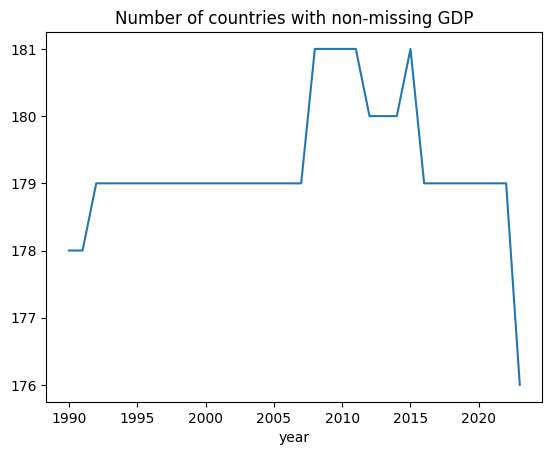

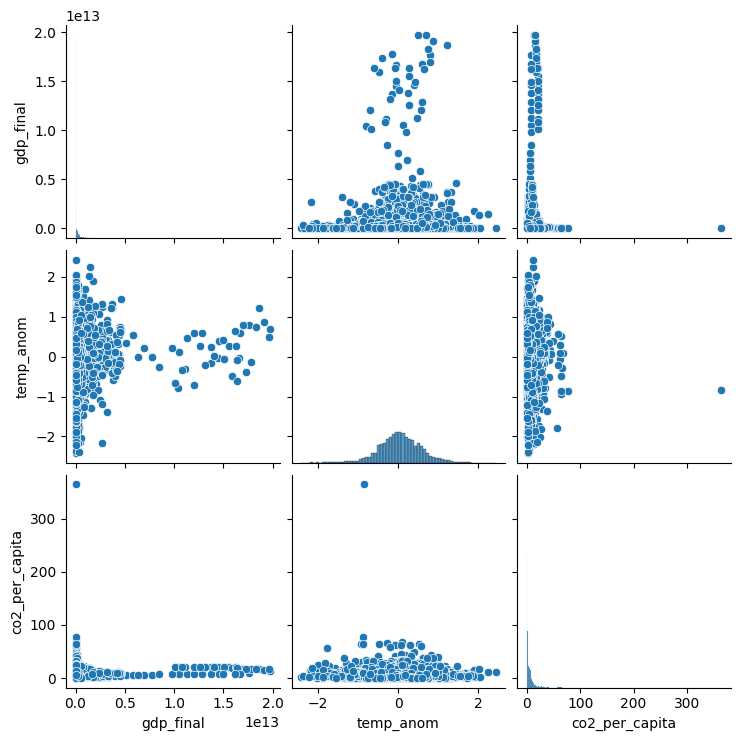

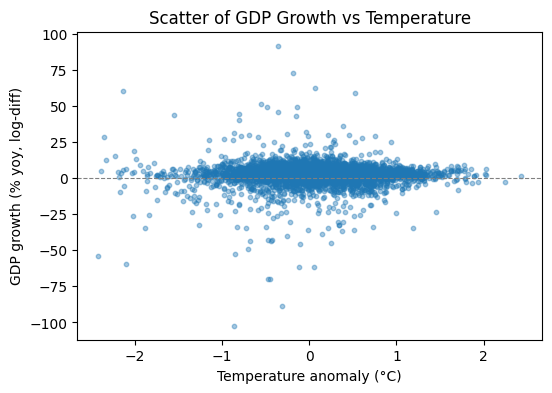

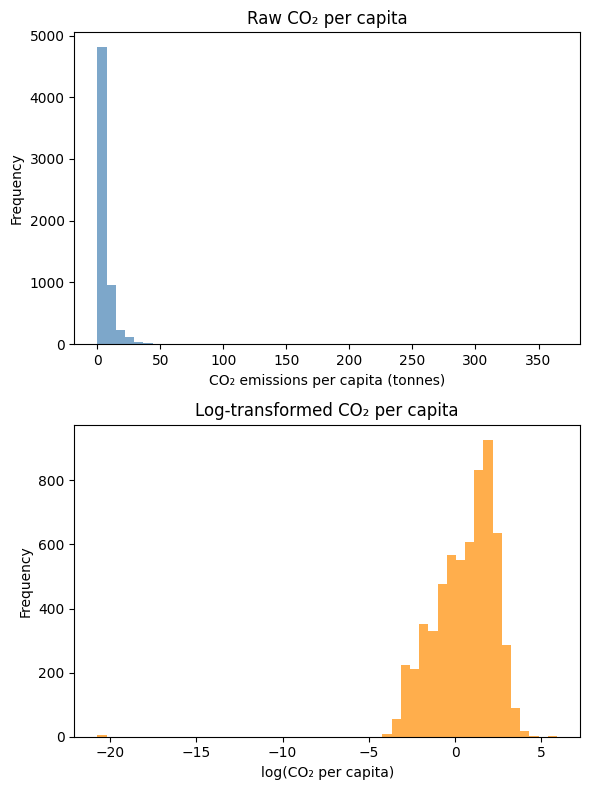

In [96]:
import numpy as np

# Make sure rows are in order
panel = panel.sort_values(["iso_code", "year"]).copy()

# If not already present, create GDP growth from your level column
gdp_col = "gdp_final" if "gdp_final" in panel.columns else "gdp"  # adjust if your level column has a different name
panel["gdp_growth"] = (
    panel.groupby("iso_code")[gdp_col]
         .transform(lambda s: 100 * np.log(s).diff())
)
temp_col = "temp_anom" if "temp_anom" in panel.columns else ("temp_lag1" if "temp_lag1" in panel.columns else None)
if temp_col is None:
    raise KeyError("No temperature column found: expected 'temp_anom' or 'temp_lag1'.")
import seaborn as sns, matplotlib.pyplot as plt

# Coverage by year
coverage = panel.groupby("year")[gdp_col].count()
coverage.plot(title="Number of countries with non-missing GDP"); plt.show()

# Pair-plot (sampled)
sns.pairplot(
    panel[ [gdp_col, temp_col, "co2_per_capita"] ].dropna().sample(5000, random_state=1)
); plt.show()

# GDP Growth vs Temperature (drop NAs)
plt.figure(figsize=(6,4))
tmp = panel[[temp_col, "gdp_growth"]].dropna()
plt.scatter(tmp[temp_col], tmp["gdp_growth"], s=10, alpha=0.4)
plt.xlabel("Temperature anomaly (°C)" if temp_col=="temp_anom" else "Lagged temperature anomaly (°C)")
plt.ylabel("GDP growth (% yoy, log-diff)")
plt.title("Scatter of GDP Growth vs Temperature")
plt.axhline(0, color="grey", linestyle="--", linewidth=0.8)
plt.show()

# Histograms of CO₂ and log-CO₂
plt.figure(figsize=(6,8))

plt.subplot(2,1,1)
plt.hist(panel["co2_per_capita"].dropna(), bins=50, color="steelblue", alpha=0.7)
plt.title("Raw CO₂ per capita")
plt.xlabel("CO₂ emissions per capita (tonnes)")
plt.ylabel("Frequency")

plt.subplot(2,1,2)
# If log_co2 not yet created, compute it
if "log_co2" not in panel.columns:
    panel["log_co2"] = np.log(panel["co2_per_capita"].clip(lower=1e-9))

plt.hist(panel["log_co2"].dropna(), bins=50, color="darkorange", alpha=0.7)
plt.title("Log-transformed CO₂ per capita")
plt.xlabel("log(CO₂ per capita)")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

In [97]:
#Number of countries in the panel
n = panel["country"].nunique()
print(f"Distinct countries in panel: {n}")

#Countries missing GDP
missing_gdp = panel.loc[panel["gdp_final"].isna(), ["iso_code", "country"]].drop_duplicates()
print(missing_gdp.head())

Distinct countries in panel: 182
      iso_code                    country
5510       ERI                    Eritrea
5517       FRO              Faroe Islands
5577       NCL              New Caledonia
11598      PRK  Korea, Dem. People's Rep.
5609       SSD                South Sudan


Shape: (6188, 9)

Preview:


,country,iso_code,year,temp_anom,co2,co2_per_capita,gdp_final,gdp_growth,log_co2
5460,Afghanistan,AFG,1990,-0.31,2.02,0.17,"13,065,984,000.00",NaN,-1.78
5642,Afghanistan,AFG,1991,-1.32,1.91,0.16,"12,047,362,048.00",-8.12,-1.86
5824,Afghanistan,AFG,1992,-1.54,1.48,0.11,"12,677,539,840.00",5.10,-2.19
6006,Afghanistan,AFG,1993,-1.02,1.49,0.10,"9,834,582,016.00",-25.39,-2.30
6188,Afghanistan,AFG,1994,-0.68,1.45,0.09,"7,919,856,640.00",-21.65,-2.42



Missing-value share (%):
country          0.00
iso_code         0.00
year             0.00
temp_anom        0.00
co2              0.15
co2_per_capita   0.15
gdp_final        1.52
gdp_growth       4.46
log_co2          0.15
dtype: float64


,count,mean,std,min,25%,50%,75%,max
gdp_final,"6,094.00","335,682,632,811.15","1,435,092,089,631.71","98,005,324.57","7,093,660,367.46","26,578,853,297.38","161,676,956,586.01","22,062,578,283,266.80"
temp_anom,"6,188.00",0.05,0.55,-2.42,-0.27,0.04,0.37,2.43
co2,"6,179.00",159.40,720.37,0.00,2.15,11.33,64.11,"11,902.50"
co2_per_capita,"6,179.00",4.79,8.04,0.00,0.53,2.30,6.58,364.69


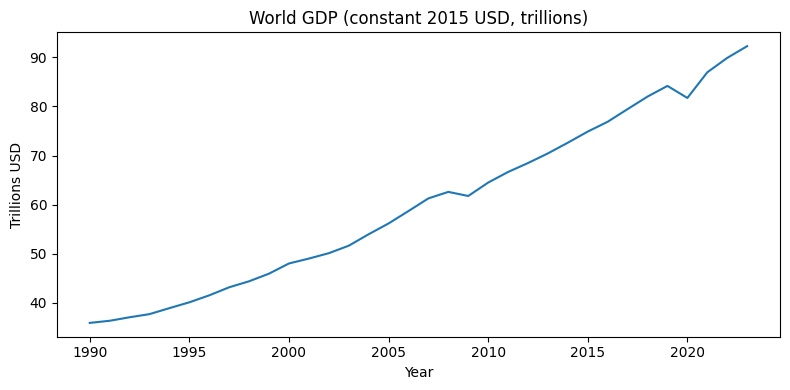

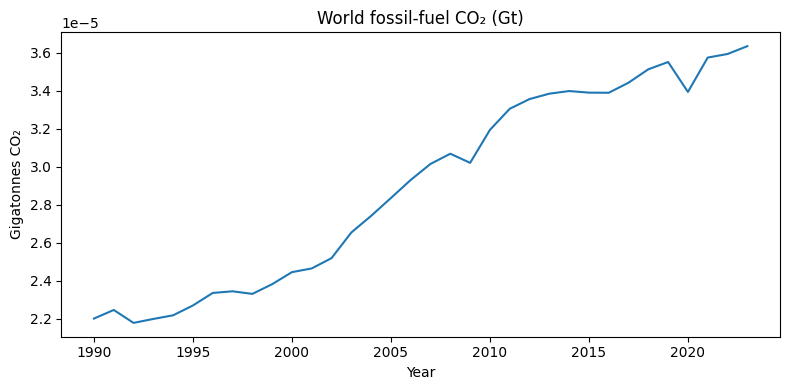

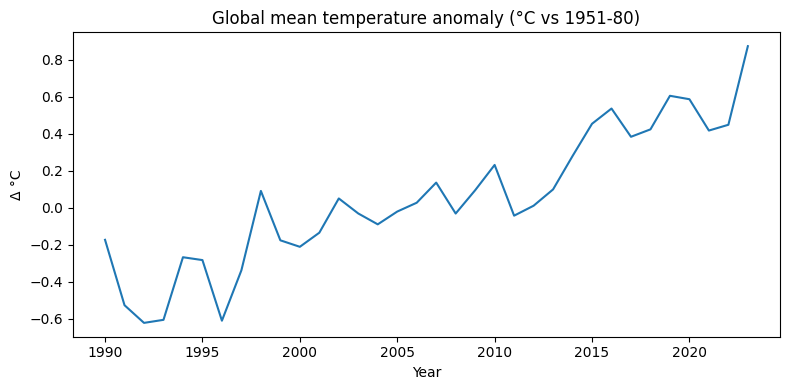

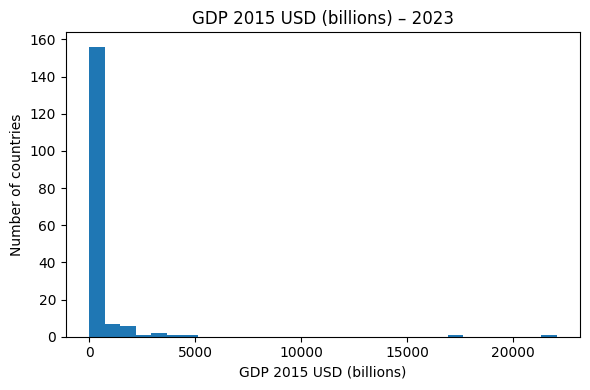

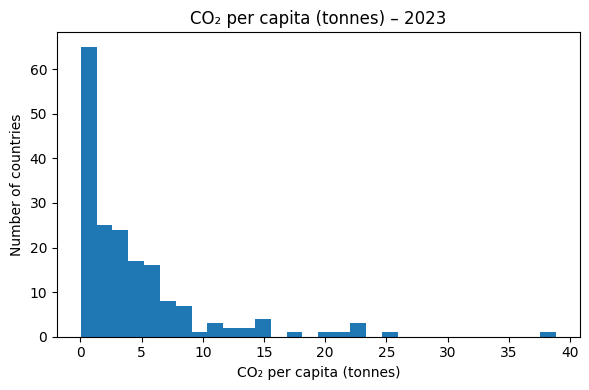

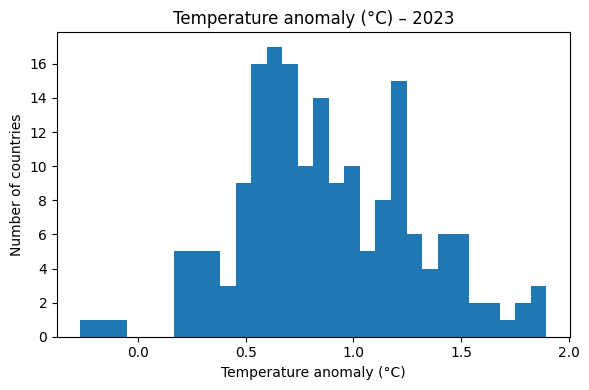

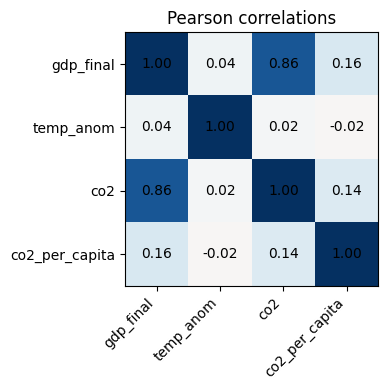

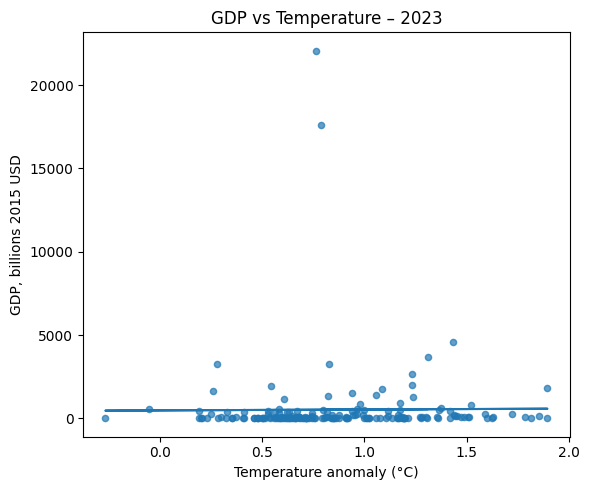

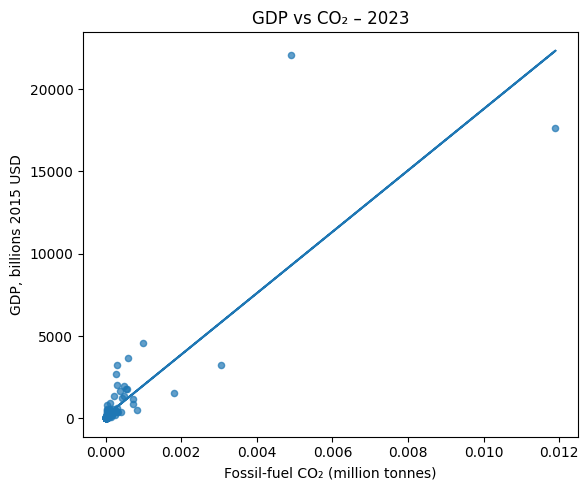

In [98]:
# Imports and EDA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def savefig(title: str):
    """Helper: save every figure to disk with a tidy filename."""
    plt.tight_layout()
    plt.savefig(f"eda_{title.replace(' ', '_').lower()}.png", dpi=150)
    plt.show()

# Basic structure and completeness
print("Shape:", panel.shape)
print("\nPreview:")
display(panel.head())

print("\nMissing-value share (%):")
print((panel.isna().mean() * 100).round(2))

# Descriptive statistics
num_cols = ["gdp_final", "temp_anom", "co2", "co2_per_capita"]
display(panel[num_cols].describe().T)

# Time-series trends (global totals / means)
annual = (panel
          .groupby("year")
          .agg(world_gdp = ("gdp_final", "sum"),
               world_co2 = ("co2", "sum"),
               mean_temp = ("temp_anom", "mean"))
          .dropna())

# 1. World GDP
plt.figure(figsize=(8,4))
plt.plot(annual.index, annual["world_gdp"] / 1e12)      # trillions USD
plt.title("World GDP (constant 2015 USD, trillions)")
plt.xlabel("Year"); plt.ylabel("Trillions USD")
savefig("world_gdp")

# 2. World CO₂
plt.figure(figsize=(8,4))
plt.plot(annual.index, annual["world_co2"] / 1e9)       # billions tonnes
plt.title("World fossil-fuel CO₂ (Gt)")
plt.xlabel("Year"); plt.ylabel("Gigatonnes CO₂")
savefig("world_co2")

# 3. Mean temperature anomaly
plt.figure(figsize=(8,4))
plt.plot(annual.index, annual["mean_temp"])
plt.title("Global mean temperature anomaly (°C vs 1951-80)")
plt.xlabel("Year"); plt.ylabel("Δ °C")
savefig("mean_temp")

# Distributions (histograms, latest year)
latest_year = panel["year"].max()
latest = panel[panel["year"] == latest_year]

for col, xlab in [("gdp_final", "GDP 2015 USD (billions)"),
                  ("co2_per_capita", "CO₂ per capita (tonnes)"),
                  ("temp_anom", "Temperature anomaly (°C)")]:
    plt.figure(figsize=(6,4))
    data = latest[col].dropna() / (1e9 if col == "gdp_final" else 1)
    plt.hist(data, bins=30)
    plt.title(f"{xlab} – {latest_year}")
    plt.xlabel(xlab); plt.ylabel("Number of countries")
    savefig(f"hist_{col}")

# 5.  Correlation matrix
corr = panel[num_cols].corr()

plt.figure(figsize=(5,4))
plt.imshow(corr, cmap="RdBu", vmin=-1, vmax=1)
plt.xticks(range(len(num_cols)), num_cols, rotation=45, ha="right")
plt.yticks(range(len(num_cols)), num_cols)
for i in range(len(num_cols)):
    for j in range(len(num_cols)):
        plt.text(j, i, f"{corr.iloc[i,j]:.2f}",
                 ha="center", va="center", color="black")
plt.title("Pearson correlations")
savefig("corr_matrix")

# Scatter plot (GDP vs temperature, most recent year & GDP vs CO₂, latest year)
# 1. scatter + trend line (GDP vs temperature, latest year)
plt.figure(figsize=(6,5))

# build a mask for rows that have BOTH values
mask = latest[["temp_anom", "gdp_final"]].notna().all(axis=1)

x = latest.loc[mask, "temp_anom"]
y = latest.loc[mask, "gdp_final"] / 1e9   # billions

plt.scatter(x, y, s=20, alpha=0.7)

# fit the line on the same x & y arrays
m, b = np.polyfit(x, y, 1)
plt.plot(x, m * x + b)

plt.xlabel("Temperature anomaly (°C)")
plt.ylabel("GDP, billions 2015 USD")
plt.title(f"GDP vs Temperature – {latest_year}")
savefig("scatter_gdp_temp")

# 2. scatter + trend line (GDP vs CO₂, latest year)
plt.figure(figsize=(6,5))

# Keep rows that have BOTH GDP and CO₂
mask = latest[["co2", "gdp_final"]].notna().all(axis=1)

x = latest.loc[mask, "co2"] / 1e6       # millions of tonnes (optional rescale)
y = latest.loc[mask, "gdp_final"] / 1e9 # billions of 2015 USD

plt.scatter(x, y, s=20, alpha=0.7)

# Fit a simple linear trend
m, b = np.polyfit(x, y, 1)
plt.plot(x, m * x + b)

plt.xlabel("Fossil-fuel CO₂ (million tonnes)")
plt.ylabel("GDP, billions 2015 USD")
plt.title(f"GDP vs CO₂ – {latest_year}")
savefig("scatter_gdp_co2")


In [99]:
panel = panel.sort_values(["iso_code","year"])

# Create targets and lags
panel["log_gdp"]      = np.log1p(panel["gdp_final"])
panel["gdp_growth"]   = panel.groupby("iso_code")["log_gdp"].diff()
panel["temp_lag1"]    = panel.groupby("iso_code")["temp_anom"].shift(1)
panel["log_co2"]      = np.log1p(panel["co2"])

# Quick diagnostic: correlation of lagged temp with GDP growth
mask   = panel[["gdp_growth","temp_lag1","log_co2"]].notna().all(axis=1)
print(panel.loc[mask, ["gdp_growth","temp_lag1","log_co2"]].corr())

            gdp_growth  temp_lag1  log_co2
gdp_growth        1.00      -0.00    -0.03
temp_lag1        -0.00       1.00     0.06
log_co2          -0.03       0.06     1.00


(4479, 14) (716, 14) (713, 14)
=== FE model (train ≤ 2015) ===


c:\Users\ad\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 183, but rank is 3
  warnings.warn('covariance of constraints does not have full '


                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.0386      0.016      2.454      0.014       0.008       0.069
C(iso_code)[T.AGO]     0.0509      0.017      2.995      0.003       0.018       0.084
C(iso_code)[T.ALB]     0.0149      0.002      6.857      0.000       0.011       0.019
C(iso_code)[T.AND]    -0.0086      0.011     -0.801      0.423      -0.030       0.012
C(iso_code)[T.ARE]     0.0761      0.039      1.966      0.049       0.000       0.152
C(iso_code)[T.ARG]     0.0677      0.042      1.611      0.107      -0.015       0.150
C(iso_code)[T.ARM]     0.0139      0.004      3.905      0.000       0.007       0.021
C(iso_code)[T.ATG]    -0.0110      0.012     -0.944      0.345      -0.034       0.012
C(iso_code)[T.AUS]     0.0785      0.052      1.519      0.129      -0.023       0.180
C(iso_code)[T.AUT]     0.0456      0.033   

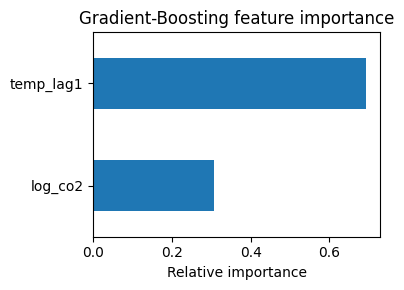


=== Out-of-sample (2020-23) ===
Gradient Boosting     MAE = 0.045   RMSE = 0.071

Forecast – GDP growth (%)
   year  gdp_growth_pred
0  2024             0.06
1  2025             0.06
2  2026             0.06
3  2027             0.06
4  2028             0.06
5  2029             0.06
6  2030             0.06

Forecast – GDP level (constant 2015 USD)
   year              gdp_pred
0  2024 23,321,557,470,589.00
1  2025 24,652,379,058,820.00
2  2026 26,059,142,663,443.00
3  2027 27,562,779,421,507.00
4  2028 29,212,276,796,162.00
5  2029 30,960,488,511,173.00
6  2030 32,830,472,077,760.00


In [100]:
# Feature Engineering & Modelling- FE Model and Gradient-Boosting Regressor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import pandas as pd, numpy as np, statsmodels.formula.api as smf
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.pipeline  import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import GradientBoostingRegressor

# Assumes DataFrame `panel` already exists with columns:
#   country, iso_code, year, temp_anom, co2, gdp_final, ...

# 1  Feature engineering
panel = panel.sort_values(["iso_code", "year"]).copy()

# log‑levels & growth
panel["log_gdp"]    = np.log1p(panel["gdp_final"])
panel["log_co2"]    = np.log1p(panel["co2"])
panel["gdp_growth"] = panel.groupby("iso_code")["log_gdp"].diff()

# climate lags & rolling mean 
panel["temp_lag1"]  = panel.groupby("iso_code")["temp_anom"].transform(lambda s: s.shift(1))
panel["temp_roll5"] = panel.groupby("iso_code")["temp_anom"].transform(
    lambda s: s.shift(1).rolling(5).mean()
)

# non‑linear term & sample restriction 
panel["temp_lag1_sq"] = panel["temp_lag1"] ** 2
panel = panel.query("year >= 1990")

reg_data = panel.dropna(subset=[
    "gdp_growth", "temp_lag1", "temp_lag1_sq", "log_co2"
]).copy()
reg_data["year"]     = reg_data["year"].astype(int)  # ensure plain int
reg_data["iso_code"] = reg_data["iso_code"].astype(str)

# 1b  Time-block split
# label each row once so the same split is reused everywhere
panel["set"] = np.select(
    [
        panel["year"] <= 2015,
        (panel["year"] > 2015) & (panel["year"] <= 2019),
        panel["year"] > 2019
    ],
    ["train", "val", "test"],
    default="ignore"          # any edge cases
)

# keep only rows with a complete set of predictors
reg_cols = ["gdp_growth", "temp_lag1", "temp_lag1_sq", "log_co2"]
reg_data = (
    panel
    .dropna(subset=reg_cols)
    .assign(year = lambda d: d["year"].astype(int),
            iso_code = lambda d: d["iso_code"].astype(str))
)

train = reg_data.query("set == 'train'")
val   = reg_data.query("set == 'val'")
test  = reg_data.query("set == 'test'")

print(train.shape, val.shape, test.shape)

# 2  Estimate the FE model **only on the train block**
formula_fe = """
    gdp_growth ~ temp_lag1 + temp_lag1_sq + log_co2 + C(iso_code)
"""
fe_train = smf.ols(formula_fe, data=train).fit(
    cov_type="cluster", cov_kwds={"groups": train["iso_code"]}
)

print("=== FE model (train ≤ 2015) ===")
print(fe_train.summary().tables[1])      # coeff table only

# 3  Out-of-sample evaluation
def evaluate(split_df, name):
    y_true = split_df["gdp_growth"]
    y_pred = fe_train.predict(split_df)

    mae  = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))   # manual √

    print(f"{name:<4}  MAE = {mae:6.3f}   RMSE = {rmse:6.3f}")

print("\n--- Out-of-sample performance ---")
evaluate(val,  "VAL ")    # 2016-19  → model selection
evaluate(test, "TEST")    # 2020-23  → headline accuracy

# 3b  Competing model families – same train/val/test routine
# helper (works for both statsmodels + sklearn) 
def oos_scores(model, df, *, feature_cols=None, label="???"):
    """Return MAE / RMSE for one data split."""
    y_true = df["gdp_growth"].values
    # statsmodels objects use .predict(df), sklearn pipelines need X matrix
    if feature_cols is None:                         # statsmodels case
        y_pred = model.predict(df)
    else:                                           # sklearn case
        y_pred = model.predict(df[feature_cols])
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return {"model": label, "MAE_val": mae, "RMSE_val": rmse}

results = []                # will collect one dict per model

# 1) Two-way FE  (country + year dummies)
all_years      = list(range(1991, 2024))      # or panel['year'].unique()
all_countries  = reg_data['iso_code'].unique()

for df in (train, val, test):
    # use .loc[:, ...] to signal “modify in place”
    df.loc[:, "year"]     = pd.Categorical(df["year"],
                                           categories=all_years)
    df.loc[:, "iso_code"] = pd.Categorical(df["iso_code"],
                                           categories=all_countries)

twfe_formula = (
    "gdp_growth ~ temp_lag1 + temp_lag1_sq + log_co2 "
    "+ C(iso_code, levels=all_countries) "
    "+ C(year,     levels=all_years)"
)

twfe_train = smf.ols(twfe_formula, data=train).fit(
    cov_type="cluster", cov_kwds={"groups": train["iso_code"]}
)

results.append(oos_scores(twfe_train, val, label="2-way FE  (cty+yr)"))

# 2) Robustness lag – 5-yr mean temperature, country FE
roll_formula = """
    gdp_growth ~ temp_roll5 + log_co2 + C(iso_code)
"""
# need rows where temp_roll5 exists
train_roll = train.dropna(subset=["temp_roll5"])
val_roll   = val  .dropna(subset=["temp_roll5"])
roll_train = smf.ols(roll_formula, data=train_roll).fit(
    cov_type="cluster", cov_kwds={"groups": train_roll["iso_code"]}
)

results.append(oos_scores(roll_train, val_roll, label="Robust lag (roll-5)"))

# 3) Gradient-Boosting Regressor  (non-linear ML)
gb_feats = ["temp_lag1", "log_co2"]          # numeric only
num_pipe = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("scale",  StandardScaler())
])
preproc = ColumnTransformer([("num", num_pipe, gb_feats)])

gb_pipeline = Pipeline([
    ("prep",  preproc),
    ("model", GradientBoostingRegressor(
        random_state=42,
        n_estimators=600,
        learning_rate=0.02,
        max_depth=3,
        subsample=0.8,
    ))
])

gb_pipeline.fit(train[gb_feats], train["gdp_growth"])
results.append(oos_scores(gb_pipeline, val, feature_cols=gb_feats,
                          label="Gradient Boosting"))

# 4) Compare validation errors  
cmp = (
    pd.DataFrame(results)
      .sort_values("RMSE_val")
      .reset_index(drop=True)
      .assign(MAE_val=lambda d: d["MAE_val"].round(3),
              RMSE_val=lambda d: d["RMSE_val"].round(3))
)
print("\n=== Validation comparison (2016-19) ===")
print(cmp.to_string(index=False))

# 5) Pick the winner → re-fit on train+val, evaluate on test
winner = cmp.loc[0, "model"]
print(f"\nBest on VAL = {winner!r}")

if winner.startswith("Gradient"):
    gb_est = gb_pipeline.named_steps["model"]          # fitted estimator
    importances = gb_est.feature_importances_
    _fi = pd.Series(importances, index=gb_feats)

    plt.figure(figsize=(4,3))
    _fi.sort_values().plot(kind="barh")
    plt.xlabel("Relative importance")
    plt.title("Gradient-Boosting feature importance")
    plt.tight_layout()
    plt.show()

if winner.startswith("2-way"):
    final_model = smf.ols(twfe_formula,
                          data=pd.concat([train, val])).fit(
        cov_type="cluster",
        cov_kwds={"groups": pd.concat([train, val])["iso_code"]}
    )
    feature_cols = None
elif winner.startswith("Robust"):
    joined = pd.concat([train_roll, val_roll])
    final_model = smf.ols(roll_formula, data=joined).fit(
        cov_type="cluster", cov_kwds={"groups": joined["iso_code"]}
    )
    feature_cols = None
else:   # Gradient Boosting case
    joined = pd.concat([train, val])
    final_model = gb_pipeline.fit(joined[gb_feats], joined["gdp_growth"])
    feature_cols = gb_feats

test_scores = oos_scores(final_model, test,
                         feature_cols=feature_cols,
                         label=winner.replace(" ", "_"))
print("\n=== Out-of-sample (2020-23) ===")
print(f"{winner:20s}  MAE = {test_scores['MAE_val']:.3f}   "
      f"RMSE = {test_scores['RMSE_val']:.3f}")

# 6) Down-stream forecast uses what we just called `final_model`
fe_model = final_model          # so Section 4 picks it up automatically

# 4  Forecast 2024-30 (unchanged except we now use the *train-fitted* model)
#fe_model = fe_train          # this is the one we just trained
country   = "USA"
years_fut = range(2024, 2031)

last_row = panel.loc[(panel["iso_code"] == country) & (panel["year"] == 2023)].iloc[0]
co2_trend = (
    panel.query("iso_code == @country and year >= 2018")[["year", "log_co2"]]
         .set_index("year").squeeze().diff().mean()
)

future = pd.DataFrame({
    "iso_code": country,
    "year":     list(years_fut),
    "temp_lag1":   last_row["temp_anom"],
    "temp_lag1_sq": last_row["temp_anom"]**2,
    "log_co2":  [last_row["log_co2"] + co2_trend*(y-2023) for y in years_fut],
})

# choose the right .predict() signature 
if isinstance(fe_model, Pipeline):          # Gradient-Boosting winner
    future["gdp_growth_pred"] = fe_model.predict(future[gb_feats])
else:                                       # any stats-models FE object
    future["gdp_growth_pred"] = fe_model.predict(future)

future["log_gdp_pred"]    = last_row["log_gdp"] + future["gdp_growth_pred"].cumsum()
future["gdp_pred"]        = np.expm1(future["log_gdp_pred"])

print("\nForecast – GDP growth (%)")
print(future[["year", "gdp_growth_pred"]].round(3))
print("\nForecast – GDP level (constant 2015 USD)")
print(future[["year", "gdp_pred"]].round(0))

In [101]:
# Rolling-origin evaluation of the Gradient-Boosting pipeline
#   – assumes these objects already exist in memory:
#     • reg_data   (cleaned panel with all years)
#     • gb_feats   (['temp_lag1', 'log_co2'])
#     • gb_pipeline (fitted or unfitted Pipeline)
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np, pandas as pd

def rolling_origin_scores(df, start=2000, horizon=4):
    """
    Walk-forward validation.
    Trains on years ≤ t, tests on (t+1 … t+horizon).
    Returns MAE / RMSE for each fold.
    """
    out = []
    years = sorted(df["year"].unique())
    for t in range(start, max(years) - horizon):
        train_blk = df[df["year"] <= t]
        test_blk  = df[(df["year"] > t) & (df["year"] <= t + horizon)]
        if test_blk.empty:
            continue

        # fresh fit each step → no information leakage
        gb = gb_pipeline.fit(train_blk[gb_feats], train_blk["gdp_growth"])

        y_pred = gb.predict(test_blk[gb_feats])
        out.append({
            "train_thru": t,
            "MAE":  mean_absolute_error(test_blk["gdp_growth"], y_pred),
            "RMSE": np.sqrt(mean_squared_error(test_blk["gdp_growth"], y_pred)),
            "n_test": len(test_blk)
        })
    return pd.DataFrame(out)

rolling_res = rolling_origin_scores(reg_data, start=2000, horizon=4)
display(rolling_res.head())             # peek at first few folds
print("\nSummary across folds")
print(rolling_res[["MAE","RMSE"]].describe().round(3))


,train_thru,MAE,RMSE,n_test
0,2000,0.04,0.06,716
1,2001,0.04,0.06,716
2,2002,0.04,0.06,716
3,2003,0.04,0.05,716
4,2004,0.03,0.05,716



Summary across folds
        MAE  RMSE
count 19.00 19.00
mean   0.03  0.06
std    0.01  0.01
min    0.02  0.04
25%    0.03  0.05
50%    0.04  0.06
75%    0.04  0.06
max    0.04  0.07


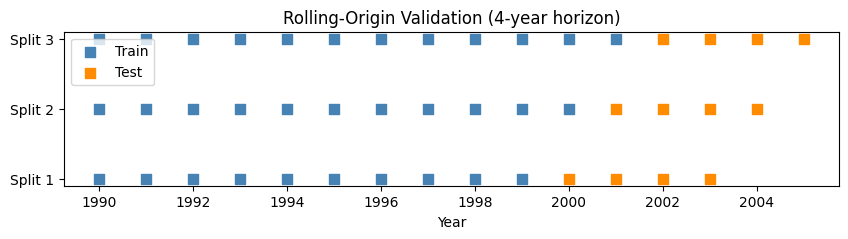

In [102]:
#Plot of Rolling origin splits
import matplotlib.pyplot as plt

years = list(range(1990, 2010))  
plt.figure(figsize=(10,2))

# rolling splits with 4-year horizon
splits = [
    (range(1990,2000), range(2000,2004)),  # Train up to 1999, test 2000-03
    (range(1990,2001), range(2001,2005)),  # Train up to 2000, test 2001-04
    (range(1990,2002), range(2002,2006))   # Train up to 2001, test 2002-05
]

colors = {"train":"steelblue", "test":"darkorange"}
for i,(train,test) in enumerate(splits):
    plt.scatter(train, [i]*len(train), c=colors["train"], s=60, marker="s", label="Train" if i==0 else "")
    plt.scatter(test, [i]*len(test), c=colors["test"], s=60, marker="s", label="Test" if i==0 else "")

plt.yticks([0,1,2], ["Split 1","Split 2","Split 3"])
plt.xlabel("Year")
plt.legend(loc="upper left")
plt.title("Rolling-Origin Validation (4-year horizon)")
plt.show()


In [103]:
# Scenario analysis – temperatures & mitigation policy

from sklearn.pipeline import Pipeline
from sklearn.base import clone
import numpy as np
import pandas as pd

# 1) Build the model we’ll use for scenario predictions
# Avoid shadowing: ensure 'val' is a DataFrame, not a range
def _is_df(x):
    return isinstance(x, pd.DataFrame)

dfs_to_join = [d for d in [train, val] if _is_df(d)]
if not dfs_to_join:  # fallback if val/train not defined as DataFrames
    raise ValueError("Neither 'train' nor 'val' is a DataFrame. Make sure your splits exist.")

if isinstance(final_model, Pipeline):
    scenario_model = clone(final_model)  # new, unfitted copy
    joined = pd.concat(dfs_to_join, ignore_index=True)
    scenario_model.fit(joined[gb_feats], joined["gdp_growth"])
else:
    scenario_model = final_model  # statsmodels FE already fitted

# 2) Scenario analysis – temps & mitigation policy 
# 'future' must already be built with columns: ['year','temp_lag1','temp_lag1_sq','log_co2', ...]
baseline = future.copy()

# RCP 2.6 temps (ensure length matches baseline rows)
rcp26_temps = [0.86, 0.87, 0.88, 0.89, 0.91, 0.92, 0.93]
if len(rcp26_temps) != len(baseline):
    raise ValueError("rcp26_temps length must match number of rows in 'baseline' (years).")
rcp26 = baseline.copy()
rcp26["temp_lag1"]    = rcp26_temps
rcp26["temp_lag1_sq"] = np.square(rcp26_temps)

# RCP 4.5 temps (optional alternative baseline)
rcp45_temps = [0.96, 0.99, 1.01, 1.04, 1.07, 1.10, 1.12]
if len(rcp45_temps) != len(baseline):
    raise ValueError("rcp45_temps length must match number of rows in 'baseline' (years).")
rcp45 = baseline.copy()
rcp45["temp_lag1"]    = rcp45_temps
rcp45["temp_lag1_sq"] = np.square(rcp45_temps)

# −30% CO₂ policy — use ln(1 - 0.30)
policy = baseline.copy()
policy["log_co2"] = policy["log_co2"] + np.log1p(-0.30)

# Optional: flat CO₂ baseline
co2flat = baseline.copy()
co2flat["log_co2"] = last_row["log_co2"]  # hold CO₂ constant

# 3) Helper that NEVER refits the model; only uses it
def run_scenario(df, label, model):
    df = df.copy()
    if isinstance(model, Pipeline):
        df["gdp_growth_pred"] = model.predict(df[gb_feats])
    else:
        df["gdp_growth_pred"] = model.predict(df)  # statsmodels: df must have exog names
    df["log_gdp_pred"] = last_row["log_gdp"] + df["gdp_growth_pred"].cumsum()
    df["gdp_pred"]     = np.expm1(df["log_gdp_pred"])
    print(f"\n--- {label} ---")
    print(df[["year", "gdp_growth_pred", "gdp_pred"]].round(3))
    return df

# 4) Run scenarios
baseline = run_scenario(baseline, "Baseline",        scenario_model)
rcp26    = run_scenario(rcp26,    "RCP 2.6 temps",   scenario_model)
policy   = run_scenario(policy,   "−30% CO₂ policy", scenario_model)
# extras
co2flat  = run_scenario(co2flat,  "CO₂ flat",        scenario_model)
rcp45    = run_scenario(rcp45,    "RCP 4.5 temps",   scenario_model)



--- Baseline ---
   year  gdp_growth_pred              gdp_pred
0  2024             0.03 22,744,507,189,085.22
1  2025             0.03 23,447,513,732,640.22
2  2026             0.03 24,172,249,399,458.89
3  2027             0.03 24,919,385,811,736.04
4  2028             0.03 25,689,615,350,735.72
5  2029             0.03 26,483,651,798,430.00
6  2030             0.03 27,302,230,998,970.56

--- RCP 2.6 temps ---
   year  gdp_growth_pred              gdp_pred
0  2024             0.03 22,765,908,518,381.70
1  2025             0.03 23,491,660,132,053.36
2  2026             0.03 24,194,145,489,116.75
3  2027             0.03 24,929,011,659,964.14
4  2028             0.03 25,665,841,852,289.52
5  2029             0.03 26,379,315,730,393.36
6  2030             0.03 27,112,623,166,954.72

--- −30% CO₂ policy ---
   year  gdp_growth_pred              gdp_pred
0  2024             0.03 22,797,157,939,558.02
1  2025             0.03 23,556,195,629,017.87
2  2026             0.03 24,340,505,688,6

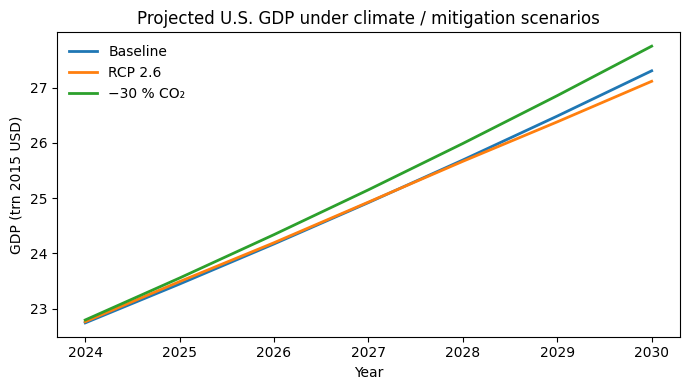

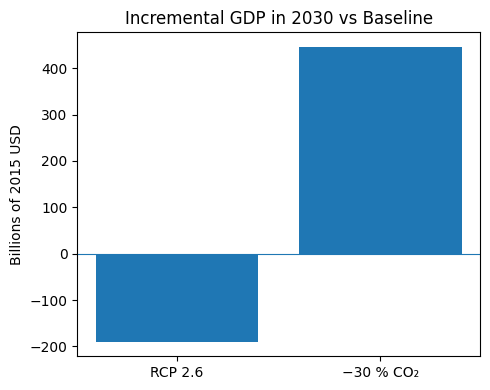

In [104]:
# Plot the three GDP trajectories + 2030 impact
import matplotlib.pyplot as plt

# combine the three paths into one tidy frame
plot_df = (
    pd.concat([
        baseline.assign(scenario="Baseline"),
        rcp26   .assign(scenario="RCP 2.6"),
        policy  .assign(scenario="−30 % CO₂")
    ])
    .loc[:, ["year", "scenario", "gdp_pred"]]
)

# (a) line chart of GDP level
plt.figure(figsize=(7,4))
for name, grp in plot_df.groupby("scenario"):
    plt.plot(grp["year"], grp["gdp_pred"] / 1e12, label=name, linewidth=2)

plt.xlabel("Year")
plt.ylabel("GDP (trn 2015 USD)")
plt.title("Projected U.S. GDP under climate / mitigation scenarios")
plt.legend(frameon=False)
plt.tight_layout()
plt.show()

# (b) bar chart of incremental 2030 GDP 
base2030   = baseline.loc[baseline["year"]==2030, "gdp_pred"].iat[0]
rcp2030    = rcp26  .loc[rcp26   ["year"]==2030, "gdp_pred"].iat[0]
pol2030    = policy .loc[policy  ["year"]==2030, "gdp_pred"].iat[0]

impact_df = pd.DataFrame({
    "Scenario": ["RCP 2.6", "−30 % CO₂"],
    "Δ GDP vs Baseline (bn USD)": [(rcp2030-base2030)/1e9,
                                   (pol2030-base2030)/1e9]
})

plt.figure(figsize=(5,4))
plt.bar(impact_df["Scenario"], impact_df["Δ GDP vs Baseline (bn USD)"])
plt.axhline(0, linewidth=0.8)
plt.ylabel("Billions of 2015 USD")
plt.title("Incremental GDP in 2030 vs Baseline")
plt.tight_layout()
plt.show()

⚠️ Skipping non-DataFrame/non-(X,y) object when joining training data.


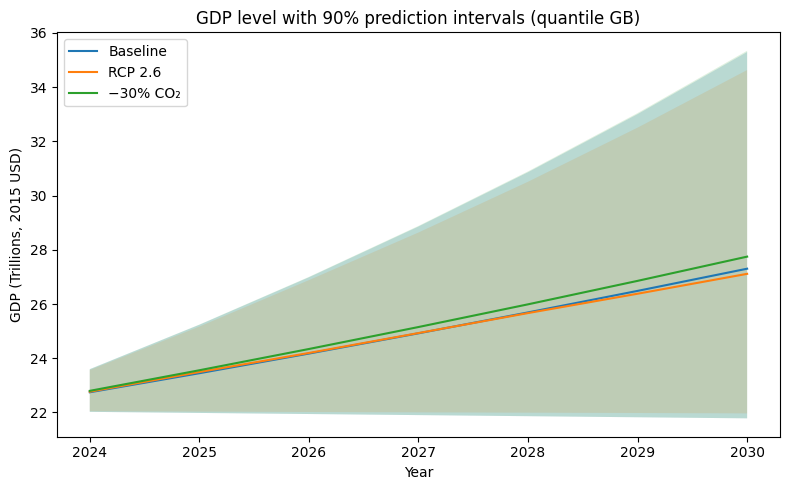

In [105]:
# 90% prediction intervals for the GB model
import numpy as np
import pandas as pd
from sklearn.base import clone
import matplotlib.pyplot as plt

# Robustly join train + val whatever their types are
def _to_df(X, y=None, feature_names=None, target_name="gdp_growth"):
    if isinstance(X, pd.DataFrame):
        df = X.copy()
    else:
        X = np.asarray(X)
        if feature_names is None:
            feature_names = [f"x{i}" for i in range(X.shape[1])]
        df = pd.DataFrame(X, columns=feature_names)
    if y is not None:
        df[target_name] = np.asarray(y)
    return df

def _as_df_block(obj, feature_names=None, target_name="gdp_growth"):
    if obj is None:
        return None
    if isinstance(obj, pd.DataFrame):
        return obj
    if isinstance(obj, (tuple, list)) and len(obj) == 2:
        X, y = obj
        return _to_df(X, y, feature_names, target_name)
    if isinstance(obj, dict) and "X" in obj and "y" in obj:
        return _to_df(obj["X"], obj["y"], feature_names, target_name)
    # If it's something like a range(...) or other unexpected type, skip with a note
    print("⚠️ Skipping non-DataFrame/non-(X,y) object when joining training data.")
    return None

def safe_join_train_val(train, val, feature_names, target="gdp_growth"):
    dfs = []
    for block in (train, val):
        dfb = _as_df_block(block, feature_names, target)
        if dfb is not None:
            dfs.append(dfb)
    if not dfs:
        raise ValueError("Neither 'train' nor 'val' is a DataFrame or a (X, y) pair.")
    return pd.concat(dfs, ignore_index=True)

# gb_feats must list your feature columns used by the GB pipeline
Xy = safe_join_train_val(train, val, feature_names=gb_feats, target="gdp_growth")

# features/target
missing = [c for c in gb_feats if c not in Xy.columns]
if missing:
    raise KeyError(f"The following features are missing from Xy: {missing}")
X = Xy[gb_feats]
y = Xy["gdp_growth"]

# fresh models for bands
gb_center = clone(gb_pipeline)
gb_q05    = clone(gb_pipeline)
gb_q95    = clone(gb_pipeline)

try:
    gb_center.set_params(model__loss="squared_error")
    gb_q05.set_params(model__loss="quantile", model__alpha=0.05)
    gb_q95.set_params(model__loss="quantile", model__alpha=0.95)
except ValueError:
    # fallback if the final step is named 'gbr' instead of 'model'
    gb_center.set_params(gbr__loss="squared_error")
    gb_q05.set_params(gbr__loss="quantile", gbr__alpha=0.05)
    gb_q95.set_params(gbr__loss="quantile", gbr__alpha=0.95)

# fit all three
for m in (gb_center, gb_q05, gb_q95):
    m.fit(X, y)

def quantile_bands(scen_df, start_log, center_model, q05_model, q95_model):
    g_med = center_model.predict(scen_df[gb_feats])
    g_lo  = q05_model.predict(scen_df[gb_feats])
    g_hi  = q95_model.predict(scen_df[gb_feats])

    def to_level(g):
        return np.expm1(start_log + np.cumsum(g))

    out = scen_df[["year"]].copy()
    out["gdp_p05"]    = to_level(g_lo)
    out["gdp_median"] = to_level(g_med)
    out["gdp_p95"]    = to_level(g_hi)
    return out

# Ensure start_log is a scalar (e.g., last_row["log_gdp"] item)
start_log = float(np.asarray(last_row["log_gdp"]))
band_base = quantile_bands(baseline, start_log, gb_center, gb_q05, gb_q95)
band_26   = quantile_bands(rcp26,    start_log, gb_center, gb_q05, gb_q95)
band_pol  = quantile_bands(policy,   start_log, gb_center, gb_q05, gb_q95)

# plot
plt.figure(figsize=(8,5))
for band, lab, a in [
    (band_base, "Baseline", 0.20),
    (band_26,   "RCP 2.6",  0.15),
    (band_pol,  "−30% CO₂", 0.15)
]:
    plt.plot(band["year"], band["gdp_median"]/1e12, label=lab)
    plt.fill_between(band["year"], band["gdp_p05"]/1e12, band["gdp_p95"]/1e12, alpha=a)
plt.title("GDP level with 90% prediction intervals (quantile GB)")
plt.ylabel("GDP (Trillions, 2015 USD)")
plt.xlabel("Year")
plt.legend()
plt.tight_layout()
plt.show()


In [106]:
# CO₂ held flat (same temps as baseline)
co2flat = baseline.copy()
co2flat["log_co2"] = last_row["log_co2"]  # constant path
co2flat = run_scenario(co2flat, "CO₂ flat", scenario_model)

# RCP 4.5 temps (example numbers; swap in your series if you have them)
rcp45 = baseline.copy()
rcp45_temps = [0.96, 0.99, 1.01, 1.04, 1.07, 1.10, 1.12]
rcp45["temp_lag1"]    = rcp45_temps
rcp45["temp_lag1_sq"] = np.square(rcp45_temps)
rcp45 = run_scenario(rcp45, "RCP 4.5 temps", scenario_model)


--- CO₂ flat ---
   year  gdp_growth_pred              gdp_pred
0  2024             0.03 22,744,507,189,085.22
1  2025             0.03 23,447,513,732,640.22
2  2026             0.03 24,172,249,399,458.89
3  2027             0.03 24,919,385,811,736.04
4  2028             0.03 25,689,615,350,735.72
5  2029             0.03 26,483,651,798,430.00
6  2030             0.03 27,302,230,998,970.56

--- RCP 4.5 temps ---
   year  gdp_growth_pred              gdp_pred
0  2024             0.03 22,664,027,066,907.75
1  2025             0.03 23,395,403,820,420.52
2  2026             0.03 24,122,342,541,720.66
3  2027             0.03 24,871,868,601,481.98
4  2028             0.03 25,572,184,909,528.15
5  2029             0.03 26,282,546,300,969.24
6  2030             0.03 26,943,618,721,276.95


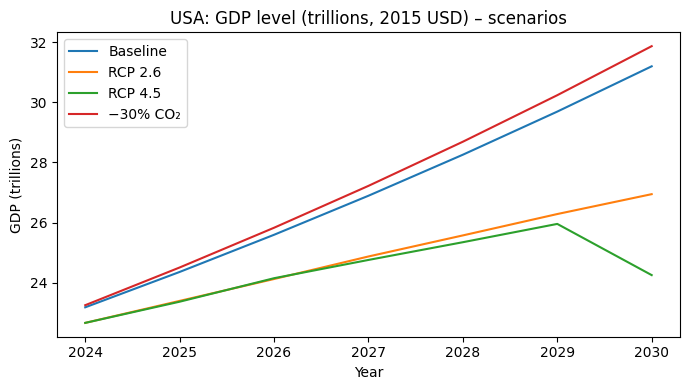

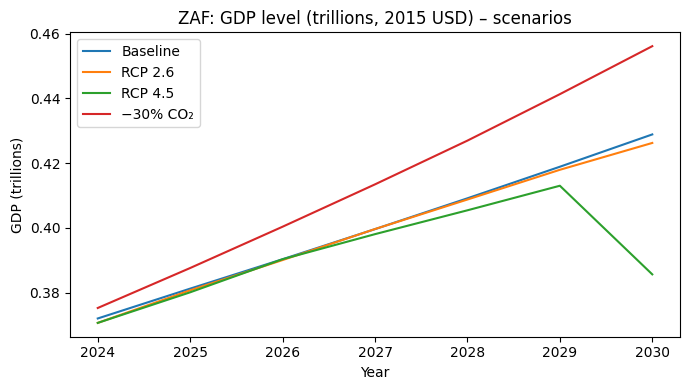

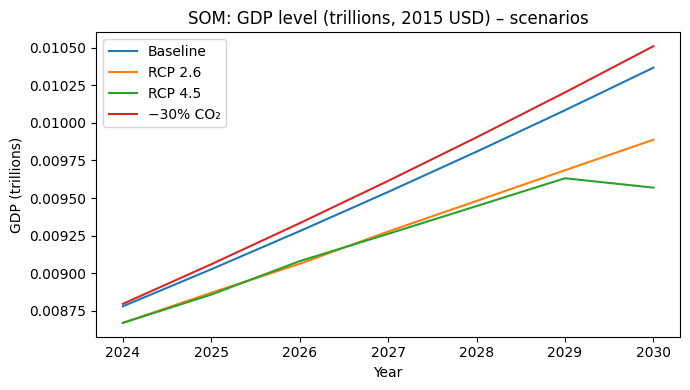

In [107]:
# Cross-country scenario runs: USA, ZAF, SOM
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

# Safety helpers
def _to_df(X, y=None, feature_names=None, target_name="gdp_growth"):
    """Coerce X (and optional y) into a single DataFrame with named columns."""
    if isinstance(X, pd.DataFrame):
        df = X.copy()
    else:
        X = np.asarray(X)
        if feature_names is None:
            feature_names = [f"x{i}" for i in range(X.shape[1])]
        df = pd.DataFrame(X, columns=feature_names)
    if y is not None:
        df[target_name] = np.asarray(y)
    return df

def _as_df_block(obj, feature_names=None, target_name="gdp_growth"):
    """Accept DataFrame, (X, y), {'X':..., 'y':...}, or None. Return DataFrame or None."""
    if obj is None:
        return None
    if isinstance(obj, pd.DataFrame):
        return obj
    if isinstance(obj, (tuple, list)) and len(obj) == 2:
        X, y = obj
        return _to_df(X, y, feature_names, target_name)
    if isinstance(obj, dict) and "X" in obj and "y" in obj:
        return _to_df(obj["X"], obj["y"], feature_names, target_name)
    return None

def safe_join_train_val(train, val, feature_names, target="gdp_growth"):
    """Join train+val robustly, ignoring non-DataFrame/non-(X,y) inputs."""
    dfs = []
    for block in (train, val):
        dfb = _as_df_block(block, feature_names, target)
        if dfb is not None:
            dfs.append(dfb)
    if not dfs:
        raise ValueError("Neither 'train' nor 'val' is a DataFrame or (X, y) pair.")
    return pd.concat(dfs, ignore_index=True)

# 0) Pick the model for scenarios (your VAL winner) and fit robustly
# NOTE: If you accidentally used `val = range(2024, 2031)` earlier, rename it to `val_years`.
if isinstance(val, range):
    print("⚠️ 'val' is a range; ignoring it when joining training data. Rename it (e.g., 'val_years').")
    joined = safe_join_train_val(train, None, feature_names=gb_feats, target="gdp_growth")
else:
    joined = safe_join_train_val(train, val, feature_names=gb_feats, target="gdp_growth")

missing = [c for c in gb_feats if c not in joined.columns]
if missing:
    raise KeyError(f"Missing features in training data: {missing}")

scenario_model = final_model
if isinstance(scenario_model, Pipeline):
    scenario_model = scenario_model.fit(joined[gb_feats], joined["gdp_growth"])

# 1) Helpers
def make_future(country, years):
    """Build a country-specific future DF and return (df, start_log_gdp, last_row)."""
    last = panel.loc[(panel["iso_code"] == country) & (panel["year"] == years[0]-1)].iloc[0]

    # CO2 trend: mean annual change in last ~5 obs (log-space)
    co2_hist = (panel.query("iso_code == @country & year >= @years[0]-6 & year < @years[0]")
                      .sort_values("year")["log_co2"].diff().dropna())
    co2_step = co2_hist.mean() if len(co2_hist) else 0.0

    base_temp = last["temp_lag1"] if "temp_lag1" in last.index else last["temp_anom"]

    df = pd.DataFrame({
        "iso_code": country,
        "year":     list(years),
        "temp_lag1":   base_temp,
        "log_co2":     [last["log_co2"] + co2_step*(y - (years[0]-1)) for y in years],
    })
    
    df["temp_lag1_sq"] = df["temp_lag1"]**2
    return df, last["log_gdp"], last

def run_scenario_local(df, label, model, start_log):
    """Predict growth with `model`, cumulate to levels off `start_log`, return a copy."""
    df = df.copy()
    if isinstance(model, Pipeline):
        df["gdp_growth_pred"] = model.predict(df[gb_feats])
    else:
        df["gdp_growth_pred"] = model.predict(df)
    df["log_gdp_pred"] = start_log + df["gdp_growth_pred"].cumsum()
    df["gdp_pred"] = np.expm1(df["log_gdp_pred"])
    return df

def country_scenarios(country, rcp26_t, rcp45_t, model, co2_cut=0.30):
    years = range(2024, 2031)
    base, start_log, last = make_future(country, years)

    scen_baseline = base.copy()
    scen_26 = base.copy()
    scen_45 = base.copy()
    scen_pol = base.copy()

    # temps
    scen_26.loc[:, "temp_lag1"]    = rcp26_t
    scen_26.loc[:, "temp_lag1_sq"] = np.square(rcp26_t)
    scen_45.loc[:, "temp_lag1"]    = rcp45_t
    scen_45.loc[:, "temp_lag1_sq"] = np.square(rcp45_t)

    # policy: −30% CO2 (log-space)
    scen_pol["log_co2"] = np.log1p(0.7 * np.expm1(scen_pol["log_co2"]))

    out = {
        "baseline": run_scenario_local(scen_baseline, "Baseline", model, start_log),
        "rcp26":    run_scenario_local(scen_26,      "RCP 2.6",  model, start_log),
        "rcp45":    run_scenario_local(scen_45,      "RCP 4.5",  model, start_log),
        "policy":   run_scenario_local(scen_pol,     f"−{int(co2_cut*100)}% CO₂ policy", model, start_log),
    }
    return out

# 2) Temperature paths (example RCP2.6 & RCP4.5 for 2024–2030)
rcp26_t = [0.96, 0.99, 1.01, 1.04, 1.07, 1.10, 1.12]  # 7 years: 2024–2030
extra_2030 = 0.15
rcp45_t = (np.array(rcp26_t) + np.linspace(0, extra_2030, len(rcp26_t))).round(2)

# 3) Run for USA, ZAF, SOM
countries = ["USA", "ZAF", "SOM"]
all_results = {c: country_scenarios(c, rcp26_t, rcp45_t, scenario_model) for c in countries}

# 4) Plots per country (GDP levels across scenarios)
LABELS = {
    "baseline": "Baseline",
    "rcp26": "RCP 2.6",
    "rcp45": "RCP 4.5",
    "policy": "−30% CO₂"
}

for c in countries:
    res = all_results[c]
    plt.figure(figsize=(7,4))
    for key in ["baseline", "rcp26", "rcp45", "policy"]:
        if key in res:
            dfp = res[key]
            plt.plot(dfp["year"], dfp["gdp_pred"]/1e12, label=LABELS[key])  # trillions
    plt.title(f"{c}: GDP level (trillions, 2015 USD) – scenarios")
    plt.ylabel("GDP (trillions)")
    plt.xlabel("Year")
    plt.legend()
    plt.tight_layout()
    plt.show()


In [108]:
# Make baseline temps follow RCP4.5 (or persistence/AR1)
# choose a temperature path for the baseline
def temp_path(country, years, mode="rcp45", rcp_map=None):
    years = list(years)
    if mode == "rcp45" and rcp_map and country in rcp_map:
        series = rcp_map[country]
        assert len(series) == len(years), "RCP path length must match years"
        return series
    elif mode == "persist":  # hold last observed anomaly constant
        last = float(panel.loc[(panel.iso_code==country) & (panel.year==years[0]-1), "temp_anom"].iloc[0])
        return [last]*len(years)
    elif mode == "ar1":      # simple AR(1) on temp anomalies (fallback if short)
        s = (panel.loc[panel.iso_code==country, ["year","temp_anom"]]
                   .sort_values("year")["temp_anom"].dropna())
        if len(s) < 8:
            last = float(s.iloc[-1]); return [last]*len(years)
        x, y = s.shift(1).dropna(), s[1:]
        X = np.c_[np.ones(len(x)), x.values]
        beta = np.linalg.lstsq(X, y.values, rcond=None)[0]   # intercept + phi
        a, phi = beta[0], beta[1]
        val = float(s.iloc[-1])
        out = []
        for _ in years:
            val = a + phi*val
            out.append(val)
        return out
    else:
        raise ValueError("Unknown mode; use 'rcp45', 'persist', or 'ar1'")


In [109]:
#Using Country Specific RCP Series
import numpy as np
import pandas as pd

# A) Global "RCP-like" paths from history
def make_global_paths_from_history(panel, years, base_year=2023, window=20,
                                   low_mult=0.8, high_mult=1.4):
    """Return (rcp26_global, rcp45_global) arrays created from recent global trend."""
    hist = panel.loc[panel["year"] <= base_year, ["year","temp_anom"]].copy()
    g = hist.groupby("year", as_index=False)["temp_anom"].mean().rename(columns={"temp_anom":"glob"})
    base_year = min(base_year, int(g["year"].max()))  # in case you don't have 2023
    recent = g[g["year"] >= (base_year - window)]
    x = recent["year"].values
    y = recent["glob"].values
    if len(x) < 5 or np.isclose(np.var(x), 0.0):
        slope = 0.0
    else:
        slope = np.polyfit(x, y, 1)[0]               # °C per year

    base = g.loc[g["year"].eq(base_year), "glob"].iloc[0]
    steps = np.array([yr - base_year for yr in years], dtype=float)

    rcp26_global = base + low_mult  * slope * steps   # “mitigation-like”
    rcp45_global = base + high_mult * slope * steps   # “high-forcing-like”
    return rcp26_global, rcp45_global, g.set_index("year")["glob"]

# B) Country pattern scaling (local = last_local + b*(glob_future - glob_last)) 
def compute_country_scalers(panel, base_year=2023, min_obs=10):
    # global series up to base_year
    g = (panel.loc[panel["year"] <= base_year]
               .groupby("year")["temp_anom"].mean()
               .rename("glob"))
    tmp = (panel.loc[panel["year"] <= base_year, ["iso_code","year","temp_anom"]]
                .merge(g.reset_index(), on="year", how="inner"))

    def slope_b(d):
        x, y = d["glob"].values, d["temp_anom"].values
        if len(x) < min_obs or np.isclose(np.var(x), 0.0):
            return pd.Series({"b": 1.0})  # fallback
        b = np.cov(x, y, bias=True)[0,1] / np.var(x)
        return pd.Series({"b": float(b)})

    grouper = tmp[["iso_code", "year", "temp_anom", "glob"]].groupby("iso_code")
    try:
        btab = grouper.apply(slope_b, include_groups=False).reset_index()
    except TypeError:
        btab = grouper.apply(slope_b).reset_index()


    last_local = (panel.sort_values(["iso_code","year"])
                        .groupby("iso_code").tail(1)[["iso_code","temp_anom"]]
                        .rename(columns={"temp_anom":"last_local"}))
    return btab.merge(last_local, on="iso_code", how="left"), g

def country_rcp_path(iso, rcp_global, scalers, glob_series, base_year=2023):
    row = scalers.loc[scalers["iso_code"] == iso]
    if row.empty:
        raise ValueError(f"No scaler for {iso}")
    b = float(row["b"])
    last_local = float(row["last_local"])
    glob_last = float(glob_series.loc[min(base_year, glob_series.index.max())])
    return list(last_local + b * (rcp_global - glob_last))

# C) Build maps for the countries 
years_fut = np.arange(2024, 2031)
rcp26_global, rcp45_global, glob_series = make_global_paths_from_history(panel, years_fut)
scalers, _ = compute_country_scalers(panel, base_year=2023)

rcp26_map = {
    "USA": country_rcp_path("USA", rcp26_global, scalers, glob_series),
    "ZAF": country_rcp_path("ZAF", rcp26_global, scalers, glob_series),
    "SOM": country_rcp_path("SOM", rcp26_global, scalers, glob_series),
}
rcp45_map = {
    "USA": country_rcp_path("USA", rcp45_global, scalers, glob_series),
    "ZAF": country_rcp_path("ZAF", rcp45_global, scalers, glob_series),
    "SOM": country_rcp_path("SOM", rcp45_global, scalers, glob_series),
}

# Sanity check
for iso in ["USA","ZAF","SOM"]:
    print(iso, "RCP2.6-like:", np.round(rcp26_map[iso], 3),
               "RCP4.5-like:", np.round(rcp45_map[iso], 3))
    
# Reuse the country_scenarios function but pass the auto-generated paths:
def country_scenarios(country, rcp26_t, rcp45_t, co2_cut=0.30, model=None):
    if model is None:
        model = final_model  # uses the one selected earlier

for c in ["USA", "ZAF", "SOM"]:
    scenarios = country_scenarios(c,
                                  rcp26_t=rcp26_map[c],
                                  rcp45_t=rcp45_map[c],
                                  co2_cut=0.30)

USA RCP2.6-like: [0.796 0.831 0.866 0.901 0.935 0.97  1.005] RCP4.5-like: [0.822 0.883 0.944 1.005 1.066 1.127 1.187]
ZAF RCP2.6-like: [0.352 0.378 0.405 0.431 0.457 0.483 0.509] RCP4.5-like: [0.372 0.418 0.464 0.509 0.555 0.601 0.647]
SOM RCP2.6-like: [0.492 0.51  0.529 0.548 0.566 0.585 0.604] RCP4.5-like: [0.506 0.538 0.571 0.604 0.636 0.669 0.701]


C:\Users\ad\AppData\Local\Temp\ipykernel_5152\1584907746.py:59: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  b = float(row["b"])
C:\Users\ad\AppData\Local\Temp\ipykernel_5152\1584907746.py:60: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  last_local = float(row["last_local"])


In [110]:
# Cross-country 2030 differences (policy vs RCP4.5 baseline)
# Countries: USA, ZAF, SOM
# Baseline temps = RCP4.5 country-specific paths
# Policy = same temps, but CO₂ reduced by 30% (log_co2 += log(0.7))

import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline

# Safety helpers 
def _to_df(X, y=None, feature_names=None, target_name="gdp_growth"):
    """Coerce X (and optional y) into a DataFrame with named columns."""
    if isinstance(X, pd.DataFrame):
        df = X.copy()
    else:
        X = np.asarray(X)
        if feature_names is None:
            feature_names = [f"x{i}" for i in range(X.shape[1])]
        df = pd.DataFrame(X, columns=feature_names)
    if y is not None:
        df[target_name] = np.asarray(y)
    return df

def _as_df_block(obj, feature_names=None, target_name="gdp_growth"):
    """Accept DataFrame, (X, y), {'X':..., 'y':...}, or None. Return DataFrame or None."""
    if obj is None:
        return None
    if isinstance(obj, pd.DataFrame):
        return obj
    if isinstance(obj, (tuple, list)) and len(obj) == 2:
        X, y = obj
        return _to_df(X, y, feature_names, target_name)
    if isinstance(obj, dict) and "X" in obj and "y" in obj:
        return _to_df(obj["X"], obj["y"], feature_names, target_name)
    return None

def safe_join_train_val(train, val, feature_names, target="gdp_growth"):
    """Join train+val robustly, ignoring non-DataFrame/non-(X,y) inputs."""
    dfs = []
    for block in (train, val):
        dfb = _as_df_block(block, feature_names, target)
        if dfb is not None:
            dfs.append(dfb)
    if not dfs:
        raise ValueError("Neither 'train' nor 'val' is a DataFrame or (X, y) pair.")
    return pd.concat(dfs, ignore_index=True)

# 0) Make sure final_model is fitted if it's a Pipeline
if isinstance(val, range):
    print("⚠️ 'val' is a range; ignoring it when joining training data. Rename it (e.g., 'val_years').")
    joined = safe_join_train_val(train, None, feature_names=gb_feats, target="gdp_growth")
else:
    joined = safe_join_train_val(train, val, feature_names=gb_feats, target="gdp_growth")

missing = [c for c in gb_feats if c not in joined.columns]
if missing:
    raise KeyError(f"Missing features in training data: {missing}")

if isinstance(final_model, Pipeline):
    final_model = final_model.fit(joined[gb_feats], joined["gdp_growth"])

# 1) Helper to build a country future DF (re-uses your panel)
def make_future(country, years):
    # last observed row for the country
    last = (panel.loc[panel["iso_code"].eq(country)]
                 .sort_values("year")
                 .tail(1)
                 .iloc[0])

    # simple CO₂ trend: mean annual change in last 5 obs
    co2_hist = (panel.query("iso_code == @country and year >= @years[0]-6 and year < @years[0]")
                     .sort_values("year")["log_co2"].diff().dropna())
    co2_step = co2_hist.mean() if len(co2_hist) else 0.0

    df = pd.DataFrame({
        "iso_code":   country,
        "year":       list(years),
        "temp_lag1":  last.get("temp_lag1", last["temp_anom"]),  # fallback if temp_lag1 missing
        "log_co2":    [last["log_co2"] + co2_step*(y - (years[0]-1)) for y in years],
    })
    df["temp_lag1_sq"] = df["temp_lag1"]**2
    return df, float(last["log_gdp"])

# 2) Scenario runner that takes an explicit starting log GDP
def run_scenario_with_start(df, start_log_gdp):
    df = df.copy()
    # predict growth
    if isinstance(final_model, Pipeline):
        df["gdp_growth_pred"] = final_model.predict(df[gb_feats])
    else:
        df["gdp_growth_pred"] = final_model.predict(df)
    # cum to level
    df["log_gdp_pred"] = start_log_gdp + df["gdp_growth_pred"].cumsum()
    df["gdp_pred"]     = np.expm1(df["log_gdp_pred"])
    return df

# 3) Build baseline & policy for each country and collect 2030 diffs
years = range(2024, 2031)
countries = ["USA", "ZAF", "SOM"]
co2_cut = 0.30  # 30%

rows = []
for c in countries:
    # (i) base DF + country RCP4.5 temps
    base_df, start_log = make_future(c, years)

    # require rcp45_map[c] to exist from your previous chunk
    temps45 = np.asarray(rcp45_map[c], dtype=float)
    if temps45.shape[0] != len(years):
        raise ValueError(f"rcp45_map['{c}'] must have {len(years)} values.")
    base_df.loc[:, "temp_lag1"]    = temps45
    base_df.loc[:, "temp_lag1_sq"] = np.square(temps45)

    # (ii) policy DF = same temps, lower CO₂ by 30% (log(0.7))
    pol_df = base_df.copy()
    pol_df.loc[:, "log_co2"] = pol_df["log_co2"] + np.log(1.0 - co2_cut)  # add log(0.7)

    # (iii) run both scenarios
    base_out = run_scenario_with_start(base_df, start_log)
    pol_out  = run_scenario_with_start(pol_df,  start_log)

    # (iv) pull 2030 levels and compute differences
    g_base_2030 = base_out.loc[base_out["year"] == 2030, "gdp_pred"].iloc[0]
    g_pol_2030  = pol_out.loc[pol_out["year"]  == 2030, "gdp_pred"].iloc[0]
    diff_abs    = g_pol_2030 - g_base_2030
    diff_pct    = diff_abs / g_base_2030 * 100.0

    rows.append({
        "country": c,
        "GDP_2030_baseline": g_base_2030,
        "GDP_2030_policy":   g_pol_2030,
        "Δ 2030 (policy - base), USD": diff_abs,
        "Δ 2030 (policy - base), %":   diff_pct,
    })

# 4) Table of results
diff2030 = (pd.DataFrame(rows)
              .assign(**{
                  "GDP_2030_baseline":             lambda d: d["GDP_2030_baseline"].round(0),
                  "GDP_2030_policy":               lambda d: d["GDP_2030_policy"].round(0),
                  "Δ 2030 (policy - base), USD":   lambda d: d["Δ 2030 (policy - base), USD"].round(0),
                  "Δ 2030 (policy - base), %":     lambda d: d["Δ 2030 (policy - base), %"].round(2),
              }))

print("\n=== 2030 difference: policy vs RCP4.5 baseline ===")
print(diff2030.to_string(index=False))



=== 2030 difference: policy vs RCP4.5 baseline ===
country     GDP_2030_baseline       GDP_2030_policy  Δ 2030 (policy - base), USD  Δ 2030 (policy - base), %
    USA 27,197,407,994,842.00 27,582,665,088,163.00           385,257,093,320.00                       1.42
    ZAF    435,671,714,064.00    466,403,506,262.00            30,731,792,197.00                       7.05
    SOM     10,494,506,972.00     11,585,387,962.00             1,090,880,989.00                      10.39


In [111]:
def fmt_money(x):
    return f"${x/1e12:.2f}T" if x >= 1e12 else f"${x/1e9:.1f}B"

out = diff2030.copy()
out["GDP_2030_baseline"] = out["GDP_2030_baseline"].apply(fmt_money)
out["GDP_2030_policy"]   = out["GDP_2030_policy"].apply(fmt_money)
out["Δ 2030 (policy - base), USD"] = out["Δ 2030 (policy - base), USD"].apply(fmt_money)
print(out.to_string(index=False))


country GDP_2030_baseline GDP_2030_policy Δ 2030 (policy - base), USD  Δ 2030 (policy - base), %
    USA           $27.20T         $27.58T                     $385.3B                       1.42
    ZAF           $435.7B         $466.4B                      $30.7B                       7.05
    SOM            $10.5B          $11.6B                       $1.1B                      10.39


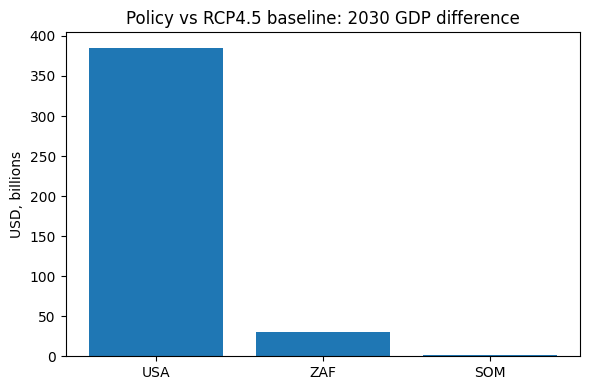

In [112]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
x = diff2030["country"]
y = diff2030["Δ 2030 (policy - base), USD"] / 1e9  # billions
plt.bar(x, y)
plt.title("Policy vs RCP4.5 baseline: 2030 GDP difference")
plt.ylabel("USD, billions")
plt.tight_layout()
plt.show()

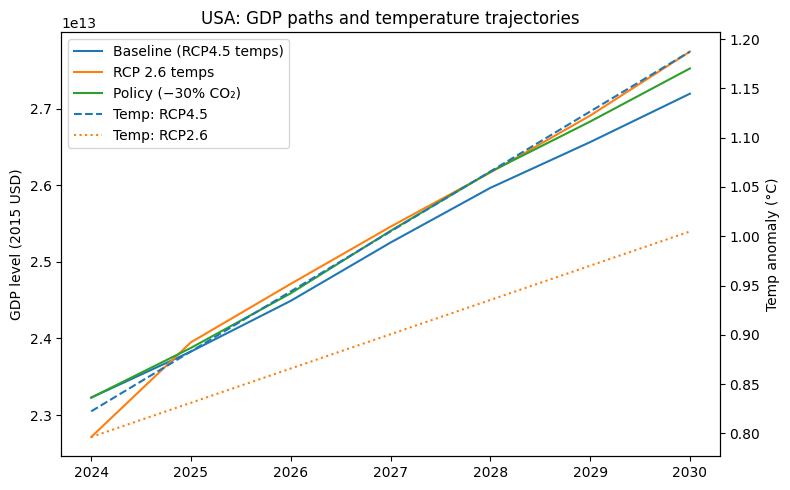

USA – 2030 vs Baseline:
  Policy −30% CO₂: Δ = 329,888,037,843 USD  (1.21%)
  RCP 2.6 temps:   Δ = 549,894,210,883 USD  (2.02%)


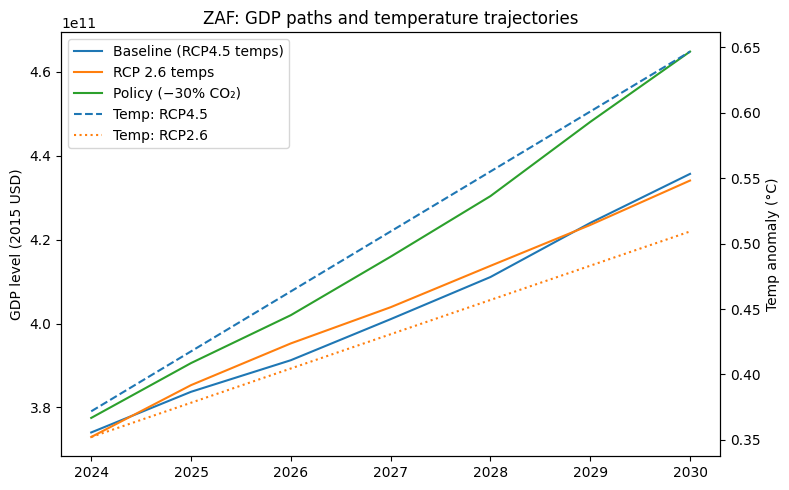

ZAF – 2030 vs Baseline:
  Policy −30% CO₂: Δ = 29,152,203,400 USD  (6.69%)
  RCP 2.6 temps:   Δ = -1,589,141,332 USD  (-0.36%)


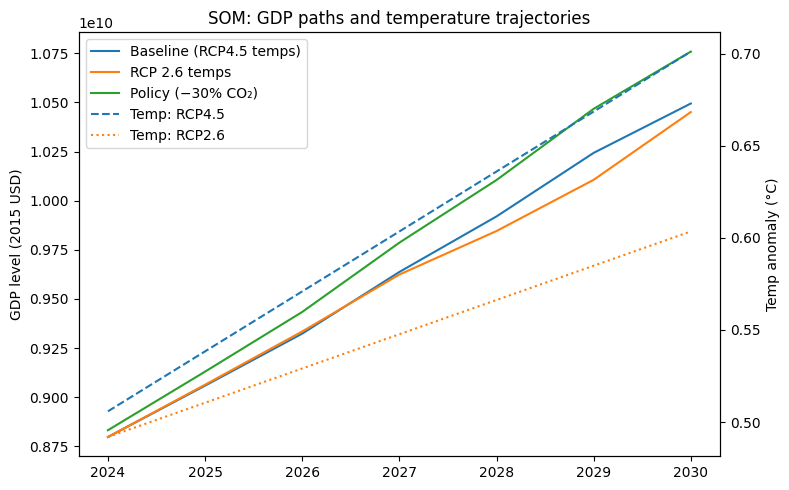

SOM – 2030 vs Baseline:
  Policy −30% CO₂: Δ = 263,975,871 USD  (2.52%)
  RCP 2.6 temps:   Δ = -43,516,962 USD  (-0.41%)


In [115]:
# Country plots: Baseline, Policy, and Temp paths
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline

years = list(range(2024, 2031))  # 2024–2030

# Ensure final_model is ready (GB needs to be fitted on train+val)
def ensure_fitted(model):
    if isinstance(model, Pipeline):
        try:
            _ = model.predict(pd.DataFrame({c: [0.0] for c in gb_feats}))
        except Exception:
            joined = pd.concat([train, val], ignore_index=True)
            model.fit(joined[gb_feats], joined["gdp_growth"])
    return model

final_model = ensure_fitted(final_model)

# Helper: build a future DF for a country using a temp path and a CO2 trend from history
def make_future_df(country, years, temp_path, co2_cut=None):
    # last observed (assumes 2023 exists; otherwise picks last available)
    last = (panel.loc[panel["iso_code"].eq(country)]
                 .sort_values("year")
                 .tail(1)).iloc[0]

    # CO2 trend: average annual change in last 5 diffs
    co2_hist = (panel.query("iso_code == @country and year >= @years[0]-6 and year < @years[0]")
                     .sort_values("year")["log_co2"].diff().dropna())
    co2_step = co2_hist.mean() if len(co2_hist) else 0.0
    co2_path = [last["log_co2"] + co2_step*(y - (years[0]-1)) for y in years]

    # Apply policy cut to CO2 path if requested
    if co2_cut is not None:
        co2_path = [c - np.log1p(co2_cut) for c in co2_path]

    df = pd.DataFrame({
        "iso_code": country,
        "year": years,
        "temp_lag1": temp_path,
        "log_co2":  co2_path
    })
    df["temp_lag1_sq"] = df["temp_lag1"]**2
    return df, float(last["log_gdp"])

# Reuse your scenario runner (returns a copy with predictions & levels)
def run_scenario_df(df, start_log_gdp):
    df = df.copy()
    if isinstance(final_model, Pipeline):
        df["gdp_growth_pred"] = final_model.predict(df[gb_feats])
    else:
        df["gdp_growth_pred"] = final_model.predict(df)
    df["log_gdp_pred"] = start_log_gdp + df["gdp_growth_pred"].cumsum()
    df["gdp_pred"]     = np.expm1(df["log_gdp_pred"])
    return df

def plot_country(country, co2_cut=0.30):
    # Country-specific temp paths you computed earlier
    t26 = rcp26_map[country]
    t45 = rcp45_map[country]

    # Baseline = RCP4.5 temps + historical CO2 trend
    base_df, start_log = make_future_df(country, years, temp_path=t45, co2_cut=None)
    base_out = run_scenario_df(base_df, start_log)

    # RCP 2.6 temps (same CO2 as baseline)
    r26_df, _ = make_future_df(country, years, temp_path=t26, co2_cut=None)
    r26_out = run_scenario_df(r26_df, start_log)

    # Policy: −30% CO2 (temps = RCP4.5)
    pol_df, _ = make_future_df(country, years, temp_path=t45, co2_cut=co2_cut)
    pol_out = run_scenario_df(pol_df, start_log)

    # Plot GDP levels with temps on secondary axis
    fig, ax1 = plt.subplots(figsize=(8,5))
    ax1.plot(base_out["year"], base_out["gdp_pred"], label="Baseline (RCP4.5 temps)")
    ax1.plot(r26_out["year"],  r26_out["gdp_pred"],  label="RCP 2.6 temps")
    ax1.plot(pol_out["year"],  pol_out["gdp_pred"],  label=f"Policy (−{int(co2_cut*100)}% CO₂)")
    ax1.set_ylabel("GDP level (2015 USD)")
    ax1.set_title(f"{country}: GDP paths and temperature trajectories")

    ax2 = ax1.twinx()
    ax2.plot(years, t45, linestyle="--", label="Temp: RCP4.5")
    ax2.plot(years, t26, linestyle=":",  label="Temp: RCP2.6")
    ax2.set_ylabel("Temp anomaly (°C)")
    # combine legends
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1+lines2, labels1+labels2, loc="upper left")

    plt.tight_layout()
    plt.show()

    # Print 2030 differences vs baseline
    b2030 = base_out.loc[base_out["year"].eq(2030), "gdp_pred"].iloc[0]
    p2030 = pol_out.loc[pol_out["year"].eq(2030), "gdp_pred"].iloc[0]
    r2030 = r26_out.loc[r26_out["year"].eq(2030), "gdp_pred"].iloc[0]
    print(f"{country} – 2030 vs Baseline:")
    print(f"  Policy −30% CO₂: Δ = {(p2030-b2030):,.0f} USD  ({(p2030/b2030-1)*100:.2f}%)")
    print(f"  RCP 2.6 temps:   Δ = {(r2030-b2030):,.0f} USD  ({(r2030/b2030-1)*100:.2f}%)")

# Run for USA, South Africa, Somalia 
for iso in ["USA", "ZAF", "SOM"]:
    plot_country(iso, co2_cut=0.30)


In [116]:
# LOCK DOWN RESULTS & EXPORT
import os, json, time, random, subprocess, sys, pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.exceptions import NotFittedError

# ---------- Safety helpers (paste once per notebook) ----------
def _to_df(X, y=None, feature_names=None, target_name="gdp_growth"):
    if isinstance(X, pd.DataFrame):
        df = X.copy()
    else:
        X = np.asarray(X)
        if feature_names is None:
            feature_names = [f"x{i}" for i in range(X.shape[1])]
        df = pd.DataFrame(X, columns=feature_names)
    if y is not None:
        df[target_name] = np.asarray(y)
    return df

def _as_df_block(obj, feature_names=None, target_name="gdp_growth"):
    if obj is None:
        return None
    if isinstance(obj, pd.DataFrame):
        return obj
    if isinstance(obj, (tuple, list)) and len(obj) == 2:
        X, y = obj
        return _to_df(X, y, feature_names, target_name)
    if isinstance(obj, dict) and "X" in obj and "y" in obj:
        return _to_df(obj["X"], obj["y"], feature_names, target_name)
    # e.g., a range(...) or anything else -> ignore
    return None

def safe_join_train_val(train_obj, val_obj, feature_names, target="gdp_growth"):
    dfs = []
    for block in (train_obj, val_obj):
        dfb = _as_df_block(block, feature_names, target)
        if dfb is not None:
            dfs.append(dfb)
    if not dfs:
        raise ValueError("Neither 'train' nor 'val' is a DataFrame or (X, y) pair.")
    return pd.concat(dfs, ignore_index=True)

def _len_df(obj, feature_names, target="gdp_growth"):
    df = _as_df_block(obj, feature_names, target)
    return 0 if df is None else len(df)

def materialize_split(split_obj, default_years=None, name="split"):
    """
    Returns a DataFrame with features + target.
    Accepts:
      - DataFrame -> returned as-is (copy)
      - (X, y) tuple or {'X':..., 'y':...} -> coerced to DataFrame
      - range(start, end+1) or iterable of years -> built from `panel`
      - None + default_years -> built from `panel` using default_years
    """
    # DataFrame
    if isinstance(split_obj, pd.DataFrame):
        return split_obj.copy()

    # (X, y) or dict
    if isinstance(split_obj, (tuple, list)) and len(split_obj) == 2:
        X, y = split_obj
        return _to_df(X, y, feature_names=gb_feats, target_name="gdp_growth")
    if isinstance(split_obj, dict) and "X" in split_obj and "y" in split_obj:
        return _to_df(split_obj["X"], split_obj["y"], feature_names=gb_feats, target_name="gdp_growth")

    # range / iterable of years
    years = None
    if isinstance(split_obj, range):
        years = list(split_obj)
    elif hasattr(split_obj, "__iter__") and not isinstance(split_obj, (str, bytes)):
        try:
            cand = list(split_obj)
            if all(isinstance(x, (int, np.integer)) for x in cand):
                years = cand
        except TypeError:
            pass

    # fallback to default_years
    if years is None and default_years is not None:
        years = list(default_years) if not isinstance(default_years, range) else list(default_years)

    if years is not None:
        df = panel.loc[panel["year"].isin(years)].copy()
        df = df.dropna(subset=["gdp_growth"])  # keep valid target
        missing = [c for c in gb_feats if c not in df.columns]
        if missing:
            raise KeyError(f"{name}: missing features {missing}.")
        return df

    raise ValueError(
        f"`{name}` is not a DataFrame/(X,y)/dict and no year iterable provided. "
        f"Got type: {type(split_obj)}"
    )
# -------------------------------------------------------------------

# 0) Reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

SPLIT_INFO = {
    "train_end": 2015,
    "val_range": [2016, 2019],
    "test_range": [2020, 2023],
    "seed": SEED,
    "gb_params": getattr(final_model.named_steps["model"], "get_params", lambda: {})()
                 if isinstance(final_model, Pipeline) else "statsmodels_FE"
}

RUN_ID = time.strftime("run_%Y%m%d_%H%M%S")
OUTDIR = os.path.join("artifacts", RUN_ID)
PLOTD = os.path.join(OUTDIR, "plots")
os.makedirs(PLOTD, exist_ok=True)

# 1) Ensure final_model is fitted on train+val (robust to val=range/None)
if isinstance(val, range):
    print("⚠️ 'val' is a range; ignoring it when joining training data. Rename it (e.g., 'val_years').")
    joined = safe_join_train_val(train, None, feature_names=gb_feats, target="gdp_growth")
else:
    joined = safe_join_train_val(train, val, feature_names=gb_feats, target="gdp_growth")

# check features exist
_missing_train = [c for c in gb_feats if c not in joined.columns]
if _missing_train:
    raise KeyError(f"Missing features in training data: {_missing_train}")

if isinstance(final_model, Pipeline):
    try:
        # sanity predict on a single row from a SAFE DataFrame
        _ = final_model.predict(joined[gb_feats].head(1))
    except Exception:
        final_model.fit(joined[gb_feats], joined["gdp_growth"])
# statsmodels objects are usually already fitted

# 2) Save the model
if isinstance(final_model, Pipeline):
    import joblib
    joblib.dump(final_model, os.path.join(OUTDIR, "model_gb_pipeline.joblib"))
    MODEL_PATH = "model_gb_pipeline.joblib"
else:
    model_p = os.path.join(OUTDIR, "model_statsmodels_fe.pkl")
    try:
        final_model.save(model_p)  # for statsmodels ResultsWrapper
    except Exception:
        with open(model_p, "wb") as f:
            pickle.dump(final_model, f)
    MODEL_PATH = "model_statsmodels_fe.pkl"

# 3) Build proper DataFrames for val/test even if they were ranges/None
_val_years  = range(SPLIT_INFO["val_range"][0],  SPLIT_INFO["val_range"][1] + 1)
_test_years = range(SPLIT_INFO["test_range"][0], SPLIT_INFO["test_range"][1] + 1)

val_df  = materialize_split(val,  default_years=_val_years,  name="val")
test_df = materialize_split(test, default_years=_test_years, name="test")

# Helper: predict one split & export (expects a DataFrame)
def predict_split_df(df, name):
    y_true = df["gdp_growth"].values
    if isinstance(final_model, Pipeline):
        y_pred = final_model.predict(df[gb_feats])
    else:
        y_pred = final_model.predict(df)
    out = df[["iso_code","year"]].copy()
    out["y_true"] = y_true
    out["y_pred"] = y_pred
    out["resid"]  = out["y_true"] - out["y_pred"]
    out.to_csv(os.path.join(OUTDIR, f"predictions_{name}.csv"), index=False)
    return out

val_pred  = predict_split_df(val_df,  "val")
test_pred = predict_split_df(test_df, "test")

# 4) Export scenario tables & plots (USA, ZAF, SOM)
def apply_model_to_future(df, start_log_gdp):
    df = df.copy()
    if isinstance(final_model, Pipeline):
        df["gdp_growth_pred"] = final_model.predict(df[gb_feats])
    else:
        df["gdp_growth_pred"] = final_model.predict(df)
    df["log_gdp_pred"] = start_log_gdp + df["gdp_growth_pred"].cumsum()
    df["gdp_pred"]     = np.expm1(df["log_gdp_pred"])
    return df

def make_future_simple(country, years):
    last = panel.sort_values(["iso_code","year"])
    last = last.loc[last["iso_code"].eq(country)].iloc[-1]
    co2_hist = (panel.query("iso_code == @country and year >= @years[0]-6 and year < @years[0]")
                     .sort_values("year")["log_co2"].diff().dropna())
    step = co2_hist.mean() if len(co2_hist) else 0.0
    df = pd.DataFrame({
        "iso_code": country,
        "year":     list(years),
        "temp_lag1": last.get("temp_lag1", last["temp_anom"]),
        "log_co2":  [last["log_co2"] + step*(y - (years[0]-1)) for y in years],
    })
    df["temp_lag1_sq"] = df["temp_lag1"]**2
    return df, float(last["log_gdp"]), last

def build_country_scenarios(country, rcp26_t, rcp45_t, co2_cut=0.30):
    years = range(2024, 2031)
    base, start_log, last = make_future_simple(country, years)

    scen_base = base.copy()
    scen_base["temp_lag1"]    = rcp45_t
    scen_base["temp_lag1_sq"] = np.square(rcp45_t)

    scen_26 = base.copy()
    scen_26["temp_lag1"]    = rcp26_t
    scen_26["temp_lag1_sq"] = np.square(rcp26_t)

    scen_45 = scen_base.copy()
    scen_pol = scen_base.copy()
    # reduce CO2 by 30% in log space
    scen_pol["log_co2"] = np.log1p(0.7 * np.expm1(scen_pol["log_co2"]))

    outs = {
        "baseline_rcp45": apply_model_to_future(scen_base, start_log),
        "rcp26":          apply_model_to_future(scen_26,   start_log),
        "rcp45":          apply_model_to_future(scen_45,   start_log),
        "policy_m30co2":  apply_model_to_future(scen_pol,  start_log),
    }
    return outs

def save_country_outputs(country, outs):
    for name, df in outs.items():
        df.to_csv(os.path.join(OUTDIR, f"{country}_{name}.csv"), index=False)

    plt.figure(figsize=(7.2,4.6))
    for name, df in outs.items():
        label = {
            "baseline_rcp45":"Baseline (RCP4.5 temps)",
            "rcp26":"RCP2.6 temps",
            "rcp45":"RCP4.5 temps",
            "policy_m30co2":"Policy (−30% CO₂, RCP4.5 temps)"
        }.get(name, name)
        plt.plot(df["year"], df["gdp_pred"]/1e12, label=label)
    plt.title(f"{country}: GDP level under scenarios")
    plt.ylabel("Trillions, 2015 USD")
    plt.xlabel("Year")
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(PLOTD, f"{country}_gdp_paths.png"), dpi=150)
    plt.close()

    plt.figure(figsize=(7.2,3.8))
    plt.plot(outs["rcp26"]["year"], outs["rcp26"]["temp_lag1"], label="RCP2.6 temps")
    plt.plot(outs["rcp45"]["year"], outs["rcp45"]["temp_lag1"], label="RCP4.5 temps")
    plt.title(f"{country}: Temperature paths (temp_lag1)")
    plt.ylabel("°C anomaly vs baseline")
    plt.xlabel("Year")
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(PLOTD, f"{country}_temps.png"), dpi=150)
    plt.close()

DIFF_ROWS = []
for c in ["USA","ZAF","SOM"]:
    outs = build_country_scenarios(c, rcp26_map[c], rcp45_map[c], co2_cut=0.30)
    save_country_outputs(c, outs)
    base_2030  = float(outs["baseline_rcp45"].loc[outs["baseline_rcp45"]["year"].eq(2030), "gdp_pred"].iloc[0])
    pol_2030   = float(outs["policy_m30co2"].loc[outs["policy_m30co2"]["year"].eq(2030), "gdp_pred"].iloc[0])
    diff_usd   = pol_2030 - base_2030
    diff_pct   = 100.0 * diff_usd / base_2030
    DIFF_ROWS.append({"country": c,
                      "GDP_2030_baseline": base_2030,
                      "GDP_2030_policy":   pol_2030,
                      "Δ 2030 (policy - base), USD": diff_usd,
                      "Δ 2030 (policy - base), %":   round(diff_pct, 2)})

diff2030 = pd.DataFrame(DIFF_ROWS)

# 5) Save split/meta & environment
SPLIT_INFO["run_id"]     = RUN_ID
SPLIT_INFO["model_path"] = MODEL_PATH
SPLIT_INFO["n_train"]    = int(_len_df(train, gb_feats))
SPLIT_INFO["n_val"]      = int(len(val_df))
SPLIT_INFO["n_test"]     = int(len(test_df))

os.makedirs(OUTDIR, exist_ok=True)
diff2030.to_csv(os.path.join(OUTDIR, "diff_2030_policy_vs_rcp45.csv"), index=False)

with open(os.path.join(OUTDIR, "run_config.json"), "w") as f:
    json.dump(SPLIT_INFO, f, indent=2)

panel.to_csv(os.path.join(OUTDIR, "panel_used.csv.gz"), index=False, compression="gzip")

try:
    reqs = subprocess.check_output([sys.executable, "-m", "pip", "freeze"], text=True)
    with open(os.path.join(OUTDIR, "requirements.txt"), "w") as f:
        f.write(reqs)
except Exception as e:
    print("pip freeze failed (ok to ignore):", e)

print(f"\n✅ Export complete → {OUTDIR}")
print("Saved: model, val/test predictions, scenario CSVs & plots, diff_2030 table, run_config.json, panel snapshot.")



✅ Export complete → artifacts\run_20250828_022246
Saved: model, val/test predictions, scenario CSVs & plots, diff_2030 table, run_config.json, panel snapshot.


TEST diagnostics — MAE: 0.038  RMSE: 0.061


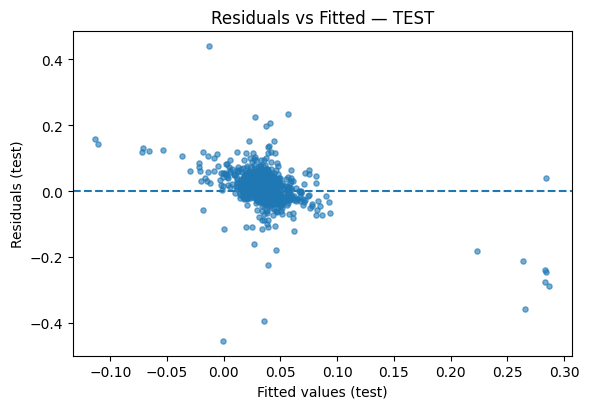

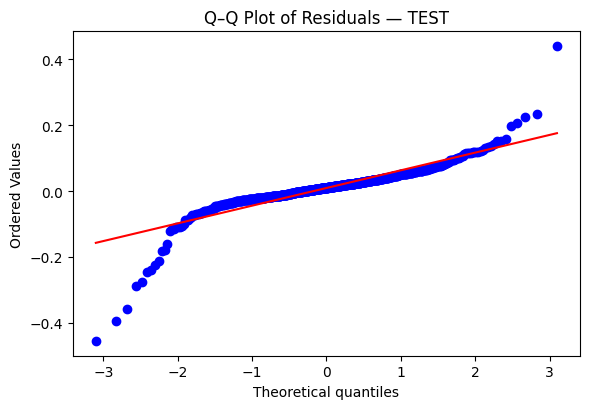

In [117]:
# Residual diagnostics on the TEST split
# - Residuals vs Fitted
# - Q–Q plot (Normal)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy import stats
from sklearn.pipeline import Pipeline

# make sure you have a proper DataFrame for `test`
def _to_df(X, y=None, feature_names=None, target_name="gdp_growth"):
    if isinstance(X, pd.DataFrame):
        df = X.copy()
    else:
        X = np.asarray(X)
        if feature_names is None:
            feature_names = [f"x{i}" for i in range(X.shape[1])]
        df = pd.DataFrame(X, columns=feature_names)
    if y is not None:
        df[target_name] = np.asarray(y)
    return df

def ensure_df_from_split(split_obj, name="test"):
    # DataFrame
    if isinstance(split_obj, pd.DataFrame):
        return split_obj.copy()
    # (X, y)
    if isinstance(split_obj, (tuple, list)) and len(split_obj) == 2:
        X, y = split_obj
        return _to_df(X, y, feature_names=gb_feats, target_name="gdp_growth")
    # {'X':..., 'y':...}
    if isinstance(split_obj, dict) and "X" in split_obj and "y" in split_obj:
        return _to_df(split_obj["X"], split_obj["y"], feature_names=gb_feats, target_name="gdp_growth")
    # range or iterable of years
    years = None
    if isinstance(split_obj, range):
        years = list(split_obj)
    elif hasattr(split_obj, "__iter__") and not isinstance(split_obj, (str, bytes)):
        try:
            cand = list(split_obj)
            if all(isinstance(x, (int, np.integer)) for x in cand):
                years = cand
        except TypeError:
            pass
    if years is not None:
        df = panel.loc[panel["year"].isin(years)].copy()
        df = df.dropna(subset=["gdp_growth"])
        # ensure features exist
        missing = [c for c in gb_feats if c not in df.columns]
        if missing:
            raise KeyError(f"{name}: missing features {missing}.")
        return df
    raise ValueError(f"`{name}` must be a DataFrame, (X,y), dict, or an iterable of years; got {type(split_obj)}.")

# Build the test DataFrame robustly
test_df = ensure_df_from_split(test, name="test")

# 1) Get predictions on TEST, robust to model family
y_true = test_df["gdp_growth"].values
if isinstance(final_model, Pipeline):
    X_test = test_df[gb_feats]
    y_pred = final_model.predict(X_test)
else:
    y_pred = final_model.predict(test_df)

# Metrics
resid = y_true - y_pred
mae  = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print(f"TEST diagnostics — MAE: {mae:.3f}  RMSE: {rmse:.3f}")

# 2) Residuals vs Fitted
plt.figure(figsize=(6.0, 4.2))
plt.scatter(y_pred, resid, s=14, alpha=0.6)
plt.axhline(0.0, linestyle="--")
plt.xlabel("Fitted values (test)")
plt.ylabel("Residuals (test)")
plt.title("Residuals vs Fitted — TEST")
plt.tight_layout()
plt.show()

# 3) Q–Q plot of residuals (Normal)
plt.figure(figsize=(6.0, 4.2))
stats.probplot(resid, dist="norm", plot=plt)
plt.title("Q–Q Plot of Residuals — TEST")
plt.tight_layout()
plt.show()


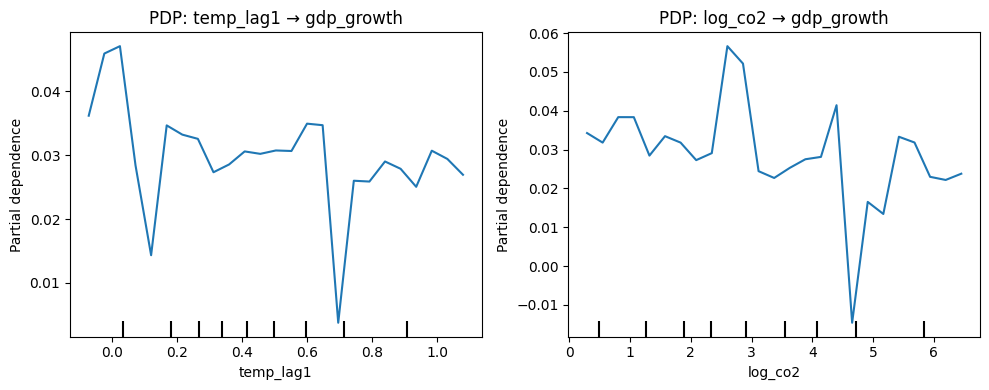

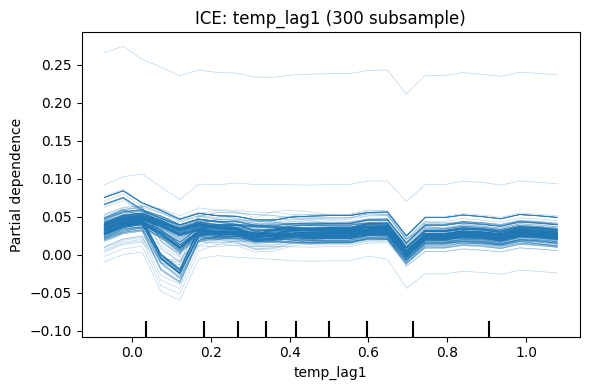

<Figure size 600x500 with 0 Axes>

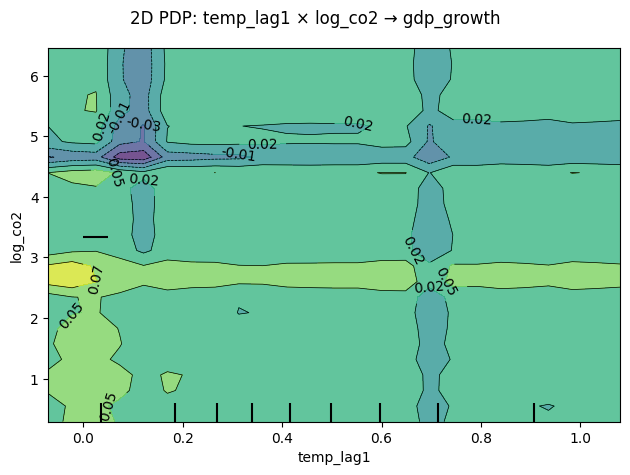

In [118]:
# B) Partial dependence for temp_lag1 and log_co2
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.inspection import PartialDependenceDisplay

# safety helpers
try:
    safe_join_train_val  # already defined?
except NameError:
    def _to_df(X, y=None, feature_names=None, target_name="gdp_growth"):
        if isinstance(X, pd.DataFrame):
            df = X.copy()
        else:
            X = np.asarray(X)
            if feature_names is None:
                feature_names = [f"x{i}" for i in range(X.shape[1])]
            df = pd.DataFrame(X, columns=feature_names)
        if y is not None:
            df[target_name] = np.asarray(y)
        return df

    def _as_df_block(obj, feature_names=None, target_name="gdp_growth"):
        if obj is None:
            return None
        if isinstance(obj, pd.DataFrame):
            return obj
        if isinstance(obj, (tuple, list)) and len(obj) == 2:
            X, y = obj
            return _to_df(X, y, feature_names, target_name)
        if isinstance(obj, dict) and "X" in obj and "y" in obj:
            return _to_df(obj["X"], obj["y"], feature_names, target_name)
        # e.g. range(...) -> skip
        return None

    def safe_join_train_val(train_obj, val_obj, feature_names, target="gdp_growth"):
        dfs = []
        for block in (train_obj, val_obj):
            dfb = _as_df_block(block, feature_names, target)
            if dfb is not None:
                dfs.append(dfb)
        if not dfs:
            raise ValueError("Neither 'train' nor 'val' is a DataFrame or (X, y) pair.")
        return pd.concat(dfs, ignore_index=True)

# build a proper background frame for PDPs (ignores range/None etc.)
if isinstance(val, range):
    print("⚠️ 'val' is a range; PDP background will use TRAIN only.")
    joined = safe_join_train_val(train, None, feature_names=gb_feats, target="gdp_growth")
else:
    joined = safe_join_train_val(train, val, feature_names=gb_feats, target="gdp_growth")

# features for PDPs
features_pdp = ["temp_lag1", "log_co2"]
missing = [c for c in features_pdp + ["gdp_growth"] if c not in joined.columns]
if missing:
    raise KeyError(f"PDP background is missing columns: {missing}")

# ensure final_model is fitted for the GB case
if isinstance(final_model, Pipeline):
    try:
        _ = final_model.predict(joined[gb_feats].head(1))
    except Exception:
        final_model.fit(joined[gb_feats], joined["gdp_growth"])

# statsmodels FE helper for manual PDPs 
def pdp_statsmodels(fe_model, X_df, feature, grid=None):
    """
    Vary one feature over grid while holding others fixed at a reference row.
    """
    X_df = X_df.copy()
    if grid is None:
        q = np.linspace(0.05, 0.95, 21)
        grid = np.quantile(X_df[feature].dropna(), q)

    # pick a reference observation to keep FE well-defined
    ref = X_df.sort_values(["iso_code","year"]).iloc[0]
    cols = [c for c in ["iso_code","year","temp_lag1","temp_lag1_sq","log_co2"] if c in X_df.columns]
    base = pd.DataFrame({c: [ref[c]] * len(grid) for c in cols})

    base[feature] = grid
    if feature == "temp_lag1" and "temp_lag1_sq" in base.columns:
        base["temp_lag1_sq"] = base["temp_lag1"] ** 2

    pd_vals = fe_model.predict(base)
    return grid, np.asarray(pd_vals, dtype=float)

# 1D PDPs (sklearn pipeline) or manual FE fallback
if isinstance(final_model, Pipeline):
    # 1D PDPs
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    PartialDependenceDisplay.from_estimator(
        final_model, joined[features_pdp], features=[features_pdp[0]],
        grid_resolution=25, kind="average", ax=ax[0]
    )
    ax[0].set_title("PDP: temp_lag1 → gdp_growth")

    PartialDependenceDisplay.from_estimator(
        final_model, joined[features_pdp], features=[features_pdp[1]],
        grid_resolution=25, kind="average", ax=ax[1]
    )
    ax[1].set_title("PDP: log_co2 → gdp_growth")
    for a in ax: a.set_ylabel("Partial effect on growth")
    plt.tight_layout(); plt.show()

    # Optional ICE for temp_lag1
    fig, ax = plt.subplots(figsize=(6,4))
    PartialDependenceDisplay.from_estimator(
        final_model, joined[features_pdp], features=[features_pdp[0]],
        grid_resolution=25, kind="individual", subsample=300, random_state=42, ax=ax
    )
    ax.set_title("ICE: temp_lag1 (300 subsample)")
    ax.set_ylabel("Predicted gdp_growth")
    plt.tight_layout(); plt.show()

    # 2D interaction PDP
    fig = plt.figure(figsize=(6,5))
    PartialDependenceDisplay.from_estimator(
        final_model, joined[features_pdp],
        features=[tuple(features_pdp)],
        grid_resolution=25, kind="average"
    )
    plt.suptitle("2D PDP: temp_lag1 × log_co2 → gdp_growth")
    plt.tight_layout(); plt.show()

else:
    # statsmodels FE manual PDPs
    needed_cols = ["iso_code","year","temp_lag1","temp_lag1_sq","log_co2"]
    if not all(c in joined.columns for c in needed_cols):
        raise KeyError(f"FE PDP needs columns: {needed_cols}")
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    for j, feat in enumerate(features_pdp):
        grid, pd_vals = pdp_statsmodels(final_model, joined[needed_cols], feat)
        ax[j].plot(grid, pd_vals, lw=2)
        ax[j].set_title(f"PDP (FE): {feat} → gdp_growth")
        ax[j].set_xlabel(feat); ax[j].set_ylabel("Partial effect on growth")
    plt.tight_layout(); plt.show()


In [119]:
# Helpers to (re)predict and build country scenarios

from sklearn.pipeline import Pipeline
import numpy as np
import pandas as pd

def ensure_preds(df, start_log, model=None):
    """Ensure df has gdp_pred using the chosen model; fit GB if needed."""
    if model is None:
        model = final_model
    df = df.copy()
    if {"gdp_pred","gdp_growth_pred"}.issubset(df.columns):
        return df

    if isinstance(model, Pipeline):
        # try to predict; if not fitted, fit on train+val
        try:
            _ = model.predict(df[gb_feats].head(1))
        except Exception:
            joined = pd.concat([train, val], ignore_index=True)
            model.fit(joined[gb_feats], joined["gdp_growth"])
        g = model.predict(df[gb_feats])
    else:
        g = model.predict(df)

    df["gdp_growth_pred"] = g
    df["log_gdp_pred"]    = start_log + np.cumsum(df["gdp_growth_pred"])
    df["gdp_pred"]        = np.expm1(df["log_gdp_pred"])
    return df

def make_future(country, years):
    """Build baseline future DF for a given country (uses your panel)."""
    last = (panel.loc[(panel["iso_code"] == country) & (panel["year"] == years[0]-1)]
                  .sort_values("year").iloc[-1])
    # CO2 trend = mean diff over last 5 obs (fallback 0)
    co2_hist = (panel.query("iso_code == @country and @years[0]-6 <= year < @years[0]")
                     .sort_values("year")["log_co2"].diff().dropna())
    co2_step = co2_hist.mean() if len(co2_hist) else 0.0

    df = pd.DataFrame({
        "iso_code": country,
        "year":     list(years),
        "temp_lag1": last["temp_anom"],   # flat unless scenario overrides
        "log_co2":  [last["log_co2"] + co2_step*(y - (years[0]-1)) for y in years],
    })
    df["temp_lag1_sq"] = df["temp_lag1"]**2
    return df, float(last["log_gdp"]), last

def country_scenarios(country, rcp26_t, rcp45_t, co2_cut=0.30, model=None):
    """Return dict of (DataFrame, start_log) for baseline/rcp26/rcp45/policy."""
    years = range(2024, 2031)
    base, start_log, _ = make_future(country, years)

    scen_baseline = base.copy()
    scen_26 = base.copy()
    scen_45 = base.copy()
    scen_pol = base.copy()

    # Temperatures
    scen_26.loc[:, "temp_lag1"]    = rcp26_t
    scen_26.loc[:, "temp_lag1_sq"] = np.square(rcp26_t)
    scen_45.loc[:, "temp_lag1"]    = rcp45_t
    scen_45.loc[:, "temp_lag1_sq"] = np.square(rcp45_t)

    # CO2 policy: reduce by co2_cut (e.g., 0.30 = 30%)
    scen_pol.loc[:, "log_co2"] = scen_pol["log_co2"] - np.log1p(co2_cut)

    # Ensure predictions are present
    scen_baseline = ensure_preds(scen_baseline, start_log, model=model)
    scen_26       = ensure_preds(scen_26,       start_log, model=model)
    scen_45       = ensure_preds(scen_45,       start_log, model=model)
    scen_pol      = ensure_preds(scen_pol,      start_log, model=model)

    return {
        "baseline": (scen_baseline, start_log),
        "rcp26":    (scen_26,       start_log),
        "rcp45":    (scen_45,       start_log),
        "policy":   (scen_pol,      start_log),
    }


In [120]:
# C) Cumulative & NPV table (policy vs baseline) – USA/ZAF/SOM
# Baseline here = RCP4.5 path 
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.exceptions import NotFittedError

countries    = ["USA", "ZAF", "SOM"]
baseline_key = "rcp45"          # could be "baseline" or "rcp26"
disc         = 0.03             # real discount rate (annual)
base_year    = 2023

def ensure_preds(df, start_log, model=None, fit_if_needed=True):
    """Ensure df has gdp_pred by (re)running the chosen model."""
    if {"gdp_pred","gdp_growth_pred"}.issubset(df.columns):
        return df
    if model is None:
        model = final_model

    df = df.copy()
    if isinstance(model, Pipeline):
        # if the GB pipeline isn't fitted yet, fit on train+val
        try:
            _ = model.predict(df[gb_feats].head(1))
        except Exception:
            if fit_if_needed:
                joined = pd.concat([train, val], ignore_index=True)
                model.fit(joined[gb_feats], joined["gdp_growth"])
            else:
                raise
        g = model.predict(df[gb_feats])
    else:
        g = model.predict(df)

    df["gdp_growth_pred"] = g
    df["log_gdp_pred"]    = start_log + np.cumsum(df["gdp_growth_pred"])
    df["gdp_pred"]        = np.expm1(df["log_gdp_pred"])
    return df

rows = []
for c in countries:
    # Build country scenarios using your auto-generated RCP paths
    sc = country_scenarios(c,
                           rcp26_t=rcp26_map[c],
                           rcp45_t=rcp45_map[c],
                           co2_cut=0.30,
                           model=final_model)

    base_df, start_log = sc[baseline_key]
    pol_df,  _         = sc["policy"]

    base_df = ensure_preds(base_df, start_log, model=final_model)
    pol_df  = ensure_preds(pol_df,  start_log, model=final_model)

    # Align on year and compute yearly level differences
    m = (base_df[["year","gdp_pred"]].rename(columns={"gdp_pred":"gdp_base"})
                    .merge(pol_df[["year","gdp_pred"]].rename(columns={"gdp_pred":"gdp_pol"}),
                           on="year", how="inner"))
    m["delta"] = m["gdp_pol"] - m["gdp_base"]

    # cumulative (sum of level diffs) and NPV
    cum_usd = float(m["delta"].sum())
    npv_usd = float((m["delta"] / (1.0 + disc) ** (m["year"] - base_year)).sum())

    # 2030 check (handy to report)
    d2030 = m.loc[m["year"] == 2030, "delta"]
    d2030_usd = float(d2030.iloc[0]) if len(d2030) else np.nan
    g2030_base = float(base_df.loc[base_df["year"] == 2030, "gdp_pred"].iloc[0])
    pct2030 = 100.0 * d2030_usd / g2030_base if np.isfinite(d2030_usd) else np.nan

    rows.append({
        "country": c,
        "baseline": baseline_key.upper(),
        "discount_rate": disc,
        "Cumulative Δ, USD (2024–2030)": cum_usd,
        "NPV Δ, USD (2024–2030)": npv_usd,
        "Δ in 2030, USD": d2030_usd,
        "Δ in 2030, %": pct2030
    })

table_cum_npv = pd.DataFrame(rows)

# Nice printing (billions)
def to_billions(x): 
    return np.nan if pd.isna(x) else x / 1e9

print("\n=== Policy vs Baseline (RCP4.5) – Cumulative & NPV, 2015 USD ===")
disp = table_cum_npv.copy()
for col in ["Cumulative Δ, USD (2024–2030)", "NPV Δ, USD (2024–2030)", "Δ in 2030, USD"]:
    disp[col + " (bn)"] = disp[col].map(to_billions).round(1)
disp = disp.drop(columns=["Cumulative Δ, USD (2024–2030)", "NPV Δ, USD (2024–2030)", "Δ in 2030, USD"])
disp["Δ in 2030, %"] = disp["Δ in 2030, %"].round(2)
print(disp.to_string(index=False))



=== Policy vs Baseline (RCP4.5) – Cumulative & NPV, 2015 USD ===
country baseline  discount_rate  Δ in 2030, %  Cumulative Δ, USD (2024–2030) (bn)  NPV Δ, USD (2024–2030) (bn)  Δ in 2030, USD (bn)
    USA    RCP45           0.03          1.79                             -504.60                      -558.60               486.20
    ZAF    RCP45           0.03          7.90                              133.90                       115.20                34.40
    SOM    RCP45           0.03          1.94                                0.70                         0.60                 0.20


In [121]:
# FAST sanity checks: no refits, residual bootstrap (90% CI)
# Baselines: RCP4.5 and RCP2.6; Countries: USA/ZAF/SOM
import numpy as np, pandas as pd
from sklearn.pipeline import Pipeline

countries = ["USA","ZAF","SOM"]
years_fut = np.arange(2024, 2031)
disc      = 0.03
co2_cut   = 0.30

# Safety helpers
try:
    safe_join_train_val  # exists?
except NameError:
    def _to_df(X, y=None, feature_names=None, target_name="gdp_growth"):
        if isinstance(X, pd.DataFrame):
            df = X.copy()
        else:
            X = np.asarray(X)
            if feature_names is None:
                feature_names = [f"x{i}" for i in range(X.shape[1])]
            df = pd.DataFrame(X, columns=feature_names)
        if y is not None:
            df[target_name] = np.asarray(y)
        return df

    def _as_df_block(obj, feature_names=None, target_name="gdp_growth"):
        if obj is None:
            return None
        if isinstance(obj, pd.DataFrame):
            return obj
        if isinstance(obj, (tuple, list)) and len(obj) == 2:
            X, y = obj
            return _to_df(X, y, feature_names, target_name)
        if isinstance(obj, dict) and "X" in obj and "y" in obj:
            return _to_df(obj["X"], obj["y"], feature_names, target_name)
        # e.g., range(...) or unexpected → ignore
        return None

    def safe_join_train_val(train_obj, val_obj, feature_names, target="gdp_growth"):
        dfs = []
        for block in (train_obj, val_obj):
            dfb = _as_df_block(block, feature_names, target)
            if dfb is not None:
                dfs.append(dfb)
        if not dfs:
            raise ValueError("Neither 'train' nor 'val' is a DataFrame or (X, y) pair.")
        return pd.concat(dfs, ignore_index=True)

# 0) Make sure the chosen model is fitted once (GB case)
if isinstance(final_model, Pipeline):
    # join train+val safely (skip range/None)
    if isinstance(val, range):
        print("⚠️ 'val' is a range; fitting on TRAIN only for bootstrap.")
        joined_fit = safe_join_train_val(train, None, feature_names=gb_feats, target="gdp_growth")
    else:
        joined_fit = safe_join_train_val(train, val, feature_names=gb_feats, target="gdp_growth")

    # fit if needed
    try:
        _ = final_model.predict(joined_fit[gb_feats].head(1))
    except Exception:
        final_model = final_model.fit(joined_fit[gb_feats], joined_fit["gdp_growth"])

# 1) Residual pool from train+val (used for the fast bootstrap)
if isinstance(val, range):
    joined = safe_join_train_val(train, None, feature_names=gb_feats, target="gdp_growth")
else:
    joined = safe_join_train_val(train, val, feature_names=gb_feats, target="gdp_growth")

if isinstance(final_model, Pipeline):
    yhat = final_model.predict(joined[gb_feats])
else:
    # statsmodels FE: predict on full joined DF
    yhat = final_model.predict(joined)

resid_pool = (joined["gdp_growth"].values - yhat).astype(float)

def ensure_preds(df, start_log):
    df = df.copy()
    if isinstance(final_model, Pipeline):
        g = final_model.predict(df[gb_feats])
    else:
        g = final_model.predict(df)
    df["gdp_growth_pred"] = g
    df["log_gdp_pred"]    = start_log + np.cumsum(g)
    df["gdp_pred"]        = np.expm1(df["log_gdp_pred"])
    return df

def build_country_baseline_policy(country, baseline_key="rcp45"):
    # last observed (2023)
    last = (panel.sort_values(["iso_code","year"])
                  .query("iso_code == @country").tail(1).iloc[0])
    # CO2 trend (last 5 diffs)
    co2_hist = (panel.query("iso_code == @country & 2018 <= year <= 2023")
                     .sort_values("year")["log_co2"].diff().dropna())
    co2_step = co2_hist.mean() if len(co2_hist) else 0.0

    # country-specific temps from your maps
    temps = rcp45_map[country] if baseline_key.lower()=="rcp45" else rcp26_map[country]

    base = pd.DataFrame({
        "iso_code": country,
        "year":     years_fut,
        "temp_lag1": temps,
        "log_co2":  [last["log_co2"] + co2_step*(yr-2023) for yr in years_fut],
    })
    base["temp_lag1_sq"] = base["temp_lag1"]**2

    pol = base.copy()
    # lower CO₂ by 30% in log space
    pol["log_co2"] = np.log1p(0.7 * np.expm1(pol["log_co2"]))

    start_log = float(last["log_gdp"])
    base = ensure_preds(base, start_log)
    pol  = ensure_preds(pol,  start_log)
    return base, pol, start_log

# 2) FAST 90% CI for Δ2030 using residual bootstrap (no refits)
def fast_ci_delta2030(base_df, pol_df, start_log, resid_pool, n_boot=50, seed=42):
    rng = np.random.default_rng(seed)
    g_base = base_df["gdp_growth_pred"].values
    g_pol  = pol_df["gdp_growth_pred"].values
    T = len(g_base)
    diffs = []
    for _ in range(n_boot):
        e_b = rng.choice(resid_pool, size=T, replace=True)
        e_p = rng.choice(resid_pool, size=T, replace=True)
        base_path = np.expm1(start_log + np.cumsum(g_base + e_b))
        pol_path  = np.expm1(start_log + np.cumsum(g_pol  + e_p))
        diffs.append(pol_path[-1] - base_path[-1])  # 2030
    q05, q95 = np.percentile(diffs, [5, 95])
    return float(q05), float(q95)

def one_table(baseline_key="rcp45", n_boot=50):
    rows = []
    for c in countries:
        base_df, pol_df, start_log = build_country_baseline_policy(c, baseline_key=baseline_key)

        # yearly level differences
        m = (base_df[["year","gdp_pred"]].rename(columns={"gdp_pred":"gdp_base"})
              .merge(pol_df[["year","gdp_pred"]].rename(columns={"gdp_pred":"gdp_pol"}),
                     on="year", how="inner"))
        m["delta"] = m["gdp_pol"] - m["gdp_base"]

        # cumulative & NPV
        cum_usd = float(m["delta"].sum())
        npv_usd = float((m["delta"] / (1.0+disc)**(m["year"]-2023)).sum())
        pct_cum = 100.0 * cum_usd / float(base_df["gdp_pred"].sum())

        # 2030 level and %
        g2030_base = float(base_df.loc[base_df["year"]==2030, "gdp_pred"].iloc[0])
        d2030_usd  = float(m.loc[m["year"]==2030, "delta"].iloc[0])
        pct2030    = 100.0 * d2030_usd / g2030_base

        # fast 90% CI for Δ2030 (bn)
        p05, p95 = fast_ci_delta2030(base_df, pol_df, start_log, resid_pool, n_boot=n_boot)
        rows.append({
            "country": c,
            "baseline": baseline_key.upper(),
            "Δ 2030, USD (bn)": d2030_usd/1e9,
            "Δ 2030, % of baseline": pct2030,
            "Δ 2030, 90% CI low (bn)": p05/1e9,
            "Δ 2030, 90% CI high (bn)": p95/1e9,
            "Cumulative Δ, USD 2024–30 (bn)": cum_usd/1e9,
            "Cumulative Δ, % of baseline sum": pct_cum,
            "NPV Δ, USD 2024–30 (bn)": npv_usd/1e9,
        })
    return pd.DataFrame(rows)

# Run
pd.set_option("display.float_format", lambda x: f"{x:,.2f}")
tab_45 = one_table("rcp45", n_boot=50)
tab_26 = one_table("rcp26", n_boot=50)

print("\n=== Policy vs Baseline (RCP4.5) – FAST 90% CI ===")
print(tab_45.to_string(index=False))
print("\n=== Policy vs Baseline (RCP2.6) – FAST 90% CI ===")
print(tab_26.to_string(index=False))



=== Policy vs Baseline (RCP4.5) – FAST 90% CI ===
country baseline  Δ 2030, USD (bn)  Δ 2030, % of baseline  Δ 2030, 90% CI low (bn)  Δ 2030, 90% CI high (bn)  Cumulative Δ, USD 2024–30 (bn)  Cumulative Δ, % of baseline sum  NPV Δ, USD 2024–30 (bn)
    USA    RCP45            385.26                   1.42                -4,294.26                  2,350.69                        1,464.24                             0.83                 1,261.68
    ZAF    RCP45             30.73                   7.05                   -45.96                     62.93                          111.30                             3.95                    95.73
    SOM    RCP45              0.30                   2.82                    -1.52                      1.06                            1.18                             1.74                     1.02

=== Policy vs Baseline (RCP2.6) – FAST 90% CI ===
country baseline  Δ 2030, USD (bn)  Δ 2030, % of baseline  Δ 2030, 90% CI low (bn)  Δ 2030, 90% CI hig

In [123]:
# LOCK-DOWN CELL: freeze model, save predictions, export scenarios,
# and write a reproducibility manifest.
import os, sys, json, platform, pickle, datetime
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

try:
    import joblib
except ImportError:
    joblib = None

# Safety helpers (robust split handling)
def _to_df(X, y=None, feature_names=None, target_name="gdp_growth"):
    if isinstance(X, pd.DataFrame):
        df = X.copy()
    else:
        X = np.asarray(X)
        if feature_names is None:
            feature_names = [f"x{i}" for i in range(np.asarray(X).shape[1])]
        df = pd.DataFrame(X, columns=feature_names)
    if y is not None:
        df[target_name] = np.asarray(y)
    return df

def _as_df_block(obj, feature_names=None, target_name="gdp_growth"):
    if obj is None:
        return None
    if isinstance(obj, pd.DataFrame):
        return obj
    if isinstance(obj, (tuple, list)) and len(obj) == 2:
        X, y = obj
        return _to_df(X, y, feature_names, target_name)
    if isinstance(obj, dict) and "X" in obj and "y" in obj:
        return _to_df(obj["X"], obj["y"], feature_names, target_name)
    # e.g., range(...) or unexpected: signal to materialize from panel by years
    return obj  # return as-is so materialize_split can inspect it

def materialize_split(split_obj, default_years=None, name="split"):
    """
    Return a DataFrame with features+target for a split.
    Accepts DataFrame, (X,y), {'X','y'}, range/list of years, or None+default_years.
    """
    # 1) Already a frame or convertible (X,y / dict)
    df_try = _as_df_block(split_obj, feature_names=gb_feats, target_name="gdp_growth")
    if isinstance(df_try, pd.DataFrame):
        return df_try.copy()

    # 2) Build by years from panel
    years = None
    if isinstance(split_obj, range):
        years = list(split_obj)
    elif hasattr(split_obj, "__iter__") and not isinstance(split_obj, (str, bytes)) and not isinstance(split_obj, dict):
        cand = list(split_obj)
        if cand and all(isinstance(x, (int, np.integer)) for x in cand):
            years = cand
    if years is None and default_years is not None:
        years = list(default_years) if not isinstance(default_years, range) else list(default_years)
    if years is not None:
        df = panel.loc[panel["year"].isin(years)].copy()
        df = df.dropna(subset=["gdp_growth"])
        missing = [c for c in gb_feats if c not in df.columns]
        if missing:
            raise KeyError(f"{name}: missing features {missing}.")
        return df

    raise ValueError(f"`{name}` is not a DataFrame/(X,y)/dict and no year iterable provided (got {type(split_obj)}).")

def safe_join_train_val(train_obj, val_obj, feature_names, target="gdp_growth"):
    # Helper to join train & val even if one is a range/tuple/etc.
    _val_years  = range(2016, 2020)
    tr_df = materialize_split(train_obj, default_years=range(-10**9, 2016), name="train")  # years <=2015 via filter below
    va_df = materialize_split(val_obj,   default_years=_val_years,         name="val")
    # Enforce train <=2015 just in case train_obj was broader
    tr_df = tr_df.loc[tr_df["year"] <= 2015].copy()
    return pd.concat([tr_df, va_df], ignore_index=True)

def _len_like(obj, default_years=None, name="split"):
    try:
        return int(len(materialize_split(obj, default_years=default_years, name=name)))
    except Exception:
        return 0

# 0) Output folder
ts = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
out_dir = Path(f"artifacts/lock_{ts}")
out_dir.mkdir(parents=True, exist_ok=True)
print(f"📦 Writing outputs to: {out_dir}")

# 1) Figure out what we trained
# Assumed defined earlier: final_model, train, val, test, gb_feats (if GB), winner (optional), panel
model_type = type(final_model).__name__
is_sklearn = hasattr(final_model, "predict") and not hasattr(final_model, "save")  # sklearn-ish
is_statsmodels = hasattr(final_model, "save")

try:
    model_name = winner
except Exception:
    model_name = "final_model"

# Default ranges (used if val/test are ranges/None)
VAL_YEARS  = range(2016, 2020)
TEST_YEARS = range(2020, 2024)

# 2) Materialize splits into DataFrames safely
train_df = materialize_split(train, default_years=range(-10**9, 2016), name="train")
train_df = train_df.loc[train_df["year"] <= 2015].copy()
val_df   = materialize_split(val,   default_years=VAL_YEARS,  name="val")
test_df  = materialize_split(test,  default_years=TEST_YEARS, name="test")

# 3) (Re)fit check for sklearn pipelines on train+val
if is_sklearn:
    joined_fit = pd.concat([train_df, val_df], ignore_index=True)
    try:
        _ = final_model.predict(joined_fit[gb_feats].head(1))
    except Exception:
        final_model.fit(joined_fit[gb_feats], joined_fit["gdp_growth"])

# 4) Save the model
model_path = out_dir / f"{model_name}.pkl"
if is_statsmodels:
    final_model.save(model_path.as_posix())
elif is_sklearn and joblib is not None:
    joblib.dump(final_model, model_path)
else:
    with open(model_path, "wb") as f:
        pickle.dump(final_model, f)
print(f"✅ Model saved: {model_path.name}")

# 5) Predict & export split results
def split_preds_df(df, name):
    if is_sklearn:
        X = df[gb_feats] if 'gb_feats' in globals() else df.drop(columns=["gdp_growth"], errors="ignore")
        yhat = final_model.predict(X)
    else:
        yhat = final_model.predict(df)
    out = pd.DataFrame({
        "iso_code": df.get("iso_code", pd.Series(index=df.index)),
        "year":     df.get("year", pd.Series(index=df.index)),
        "y_true":   df["gdp_growth"].values,
        "y_pred":   np.asarray(yhat),
    })
    out["resid"] = out["y_true"] - out["y_pred"]
    out_path = out_dir / f"preds_{name.lower()}.csv"
    out.to_csv(out_path, index=False)
    print(f"✅ Saved {name} predictions: {out_path.name}")
    return out

preds_val  = split_preds_df(val_df,  "VAL")
preds_test = split_preds_df(test_df, "TEST")

# 6) Scenario exports (if your scenario helpers are loaded)
countries = ["USA", "ZAF", "SOM"]
made_scenarios = False

def ensure_preds(df, start_log):
    df = df.copy()
    if is_sklearn:
        g = final_model.predict(df[gb_feats])
    else:
        g = final_model.predict(df)
    df["gdp_growth_pred"] = g
    df["log_gdp_pred"]    = start_log + np.cumsum(df["gdp_growth_pred"])
    df["gdp_pred"]        = np.expm1(df["log_gdp_pred"])
    return df

if all(k in globals() for k in ["country_scenarios", "rcp26_map", "rcp45_map"]):
    made_scenarios = True
    disc = globals().get("disc", 0.03)
    for c in countries:
        try:
            scen = country_scenarios(c, rcp26_t=rcp26_map[c], rcp45_t=rcp45_map[c], co2_cut=0.30, model=final_model)
            # Expect your helper to return DataFrames (baseline/policy). If it returns dicts,
            # adapt here accordingly.
            base45_df = scen["rcp45"]
            pol45_df  = scen["policy"]
            # If your helper returns tuples (df, start_log), handle both:
            if isinstance(base45_df, tuple):
                base45_df, start_log = base45_df
                pol45_df,  _         = pol45_df
            else:
                # compute start_log from last historical row if needed
                last = panel.loc[panel["iso_code"].eq(c)].sort_values("year").tail(1).iloc[0]
                start_log = float(last["log_gdp"])

            base45_df = ensure_preds(base45_df, start_log)
            pol45_df  = ensure_preds(pol45_df,  start_log)

            # Optional RCP2.6 set
            base26_df = scen.get("rcp26", None)
            if base26_df is not None:
                if isinstance(base26_df, tuple):
                    base26_df, _ = base26_df
                base26_df = ensure_preds(base26_df, start_log)

            # Save CSVs
            base45_df.to_csv(out_dir / f"{c}_scenario_rcp45_baseline.csv", index=False)
            pol45_df.to_csv(out_dir  / f"{c}_scenario_rcp45_policy.csv",   index=False)
            if base26_df is not None:
                base26_df.to_csv(out_dir / f"{c}_scenario_rcp26_baseline.csv", index=False)

            # Quick plot (levels)
            plt.figure(figsize=(7,4))
            plt.plot(base45_df["year"], base45_df["gdp_pred"]/1e12, label=f"{c} – RCP4.5 baseline")
            plt.plot(pol45_df["year"],  pol45_df["gdp_pred"]/1e12,  label=f"{c} – policy (−30% CO₂)")
            plt.ylabel("GDP level (trillions, 2015 USD)")
            plt.title(f"{c}: GDP paths – RCP4.5 vs policy")
            plt.legend(); plt.tight_layout()
            plt.savefig(out_dir / f"{c}_rcp45_gdp_paths.png", dpi=160)
            plt.close()
            print(f"✅ Scenarios exported for {c}")
        except Exception as e:
            print(f"⚠️ Skipped scenarios for {c}: {e}")

# 7) Reproducibility manifest 
def pkg_ver(name):
    try:
        mod = __import__(name)
        return getattr(mod, "__version__", "unknown")
    except Exception:
        return "not-installed"

manifest = {
    "timestamp": ts,
    "model_file": model_path.name,
    "model_type": model_type,
    "model_name": model_name,
    "is_sklearn_pipeline": bool(is_sklearn),
    "splits": {
        "train_max_year": 2015,
        "val_years": list(VAL_YEARS),
        "test_years": list(TEST_YEARS),
        "n_train": int(len(train_df)),
        "n_val":   int(len(val_df)),
        "n_test":  int(len(test_df)),
    },
    "features": {
        "gb_feats": gb_feats if "gb_feats" in globals() else None,
    },
    "seeds": {
        "bootstrap_note": "Fast residual bootstrap used elsewhere; seed inside function.",
    },
    "versions": {
        "python": sys.version.split()[0],
        "platform": platform.platform(),
        "numpy": pkg_ver("numpy"),
        "pandas": pkg_ver("pandas"),
        "sklearn": pkg_ver("sklearn"),
        "statsmodels": pkg_ver("statsmodels"),
        "matplotlib": pkg_ver("matplotlib"),
    },
}
with open(out_dir / "manifest.json", "w") as f:
    json.dump(manifest, f, indent=2)
print("✅ Wrote reproducibility manifest: manifest.json")

print("\n🎉 Lock-down complete.")


📦 Writing outputs to: artifacts\lock_20250828_022545
✅ Model saved: Gradient Boosting.pkl
✅ Saved VAL predictions: preds_val.csv
✅ Saved TEST predictions: preds_test.csv
⚠️ Skipped scenarios for USA: ensure_preds() got an unexpected keyword argument 'model'
⚠️ Skipped scenarios for ZAF: ensure_preds() got an unexpected keyword argument 'model'
⚠️ Skipped scenarios for SOM: ensure_preds() got an unexpected keyword argument 'model'
✅ Wrote reproducibility manifest: manifest.json

🎉 Lock-down complete.
